# Предсказание стоимости жилья 
Тестовое задание для компании "Вебби".

## Основная задача

Построение модели предсказания стоимости жилья на основе имеющихся данных.

## Описание данных

1. LandContour: Flatness of the property

        Lvl	Near Flat/Level	
        Bnk	Banked - Quick and significant rise from street grade to building
        HLS	Hillside - Significant slope from side to side
        Low	Depression  
       
2. GarageYrBlt: Year garage was built
3. FullBath: Basement full bathrooms
4. 1stFlrSF: First Floor square feet
5. BsmtFinSF1: Type 1 finished square feet
6. TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
7. ExterQual: Evaluates the quality of the material on the exterior 
		
        Ex	Excellent
        Gd	Good
        TA	Average/Typical
        Fa	Fair
        Po	Poor
8. OpenPorchSF: Open porch area in square feet
9. Heating: Type of heating
		
        Floor	Floor Furnace
        GasA	Gas forced warm air furnace
        GasW	Gas hot water or steam heat
        Grav	Gravity furnace	
        OthW	Hot water or steam heat other than gas
        Wall	Wall furnace
10. Condition2: Proximity to various conditions (if more than one is present)
		
        Artery	Adjacent to arterial street
        Feedr	Adjacent to feeder street	
        Norm	Normal	
        RRNn	Within 200' of North-South Railroad
        RRAn	Adjacent to North-South Railroad
        PosN	Near positive off-site feature--park, greenbelt, etc.
        PosA	Adjacent to postive off-site feature
        RRNe	Within 200' of East-West Railroad
        RRAe	Adjacent to East-West Railroad 
11. OverallQual: Rates the overall material and finish of the house

        10	Very Excellent
        9	Excellent
        8	Very Good
        7	Good
        6	Above Average
        5	Average
        4	Below Average
        3	Fair
        2	Poor
        1	Very Poor        
12. GarageCars: Size of garage in car capacity
13. KitchenQual: Kitchen quality

        Ex	Excellent
        Gd	Good
        TA	Typical/Average
        Fa	Fair
        Po	Poor
14. KitchenAbvGr
15. GrLivArea: Above grade (ground) living area square feet
16. 2ndFlrSF: Second floor square feet
17. CentralAir: Central air conditioning

        N	No
        Y	Yes


18. TotalBsmtSF: Total square feet of basement area

19. BsmtQual: Evaluates the height of the basement

        Ex	Excellent (100+ inches)	
        Gd	Good (90-99 inches)
        TA	Typical (80-89 inches)
        Fa	Fair (70-79 inches)
        Po	Poor (<70 inches
        NA	No Basement   

20. Fireplaces: Number of fireplaces     
21. SalePrice

## Метрика

Метрики для регрессии: R2, MAPE.

## План реализации

- Загрузка данных
- Предобработка и исследовательский анализ данных
- Обучение моделей
- Тестирование и анализ лучшей модели
- Заключение  


## Инструменты

In [1]:
import pandas as pd
import numpy as np
import phik
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MaxAbsScaler
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

sns.set(style="darkgrid",font_scale=1.5)
pd.set_option("display.max.columns",None)
pd.set_option("display.max.rows",None)

RANDOM_STATE = 12345

## Загрузка данных

In [2]:
%load_ext watermark
%watermark -a 'Flat_cost_webbee' -u -d -v -p pandas,sklearn,numpy,matplotlib,seaborn,phik,catboost,lightgbm

Author: Flat_cost_webbee

Last updated: 2024-05-06

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

pandas    : 2.0.3
sklearn   : 1.3.0
numpy     : 1.24.3
matplotlib: 3.7.2
seaborn   : 0.12.2
phik      : 0.12.3
catboost  : 1.2
lightgbm  : 4.1.0



In [3]:
# выводим информацию о данных датафреймов
DATA_TRAIN = '/Users/urvanov_aleksandr/Documents/Yandex/Projects/test_webbee/train.csv'
DATA_TEST = '/Users/urvanov_aleksandr/Documents/Yandex/Projects/test_webbee/test.csv'

# df1 - датафрейм с данными для обучения модели
df1 = pd.read_csv(f'{DATA_TRAIN}')

# df2 - датафрейм с данными для тестирования модели
df2 = pd.read_csv(f'{DATA_TEST}')

# выведем общую информацию о датафреймах
def info (df):
    display(df.head(3))
    df.info()

for i in [df1, df2]:
    info(i)  
    

,LandContour,GarageYrBlt,FullBath,1stFlrSF,BsmtFinSF1,TotRmsAbvGrd,ExterQual,OpenPorchSF,Heating,Condition2,OverallQual,GarageCars,KitchenQual,KitchenAbvGr,GrLivArea,2ndFlrSF,CentralAir,BsmtQual,TotalBsmtSF,Fireplaces,SalePrice
0,Lvl,2003.0,2,856,706,8,Gd,61,GasA,Norm,7,2,Gd,1,1710,854,Y,Gd,856,0,208500
1,Lvl,1976.0,2,1262,978,6,TA,0,GasA,Norm,6,2,TA,1,1262,0,Y,Gd,1262,1,181500
2,Lvl,2001.0,2,920,486,6,Gd,42,GasA,Norm,7,2,Gd,1,1786,866,Y,Gd,920,1,223500


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LandContour   1460 non-null   object 
 1   GarageYrBlt   1379 non-null   float64
 2   FullBath      1460 non-null   int64  
 3   1stFlrSF      1460 non-null   int64  
 4   BsmtFinSF1    1460 non-null   int64  
 5   TotRmsAbvGrd  1460 non-null   int64  
 6   ExterQual     1460 non-null   object 
 7   OpenPorchSF   1460 non-null   int64  
 8   Heating       1460 non-null   object 
 9   Condition2    1460 non-null   object 
 10  OverallQual   1460 non-null   int64  
 11  GarageCars    1460 non-null   int64  
 12  KitchenQual   1460 non-null   object 
 13  KitchenAbvGr  1460 non-null   int64  
 14  GrLivArea     1460 non-null   int64  
 15  2ndFlrSF      1460 non-null   int64  
 16  CentralAir    1460 non-null   object 
 17  BsmtQual      1423 non-null   object 
 18  TotalBsmtSF   1460 non-null 

,LandContour,GarageYrBlt,FullBath,1stFlrSF,BsmtFinSF1,TotRmsAbvGrd,ExterQual,OpenPorchSF,Heating,Condition2,OverallQual,GarageCars,KitchenQual,KitchenAbvGr,GrLivArea,2ndFlrSF,CentralAir,BsmtQual,TotalBsmtSF,Fireplaces
0,Lvl,1961.0,1,896,468.0,5,TA,0,GasA,Norm,5,1.0,TA,1,896,0,Y,TA,882.0,0
1,Lvl,1958.0,1,1329,923.0,6,TA,36,GasA,Norm,6,1.0,Gd,1,1329,0,Y,TA,1329.0,0
2,Lvl,1997.0,2,928,791.0,6,TA,34,GasA,Norm,5,2.0,TA,1,1629,701,Y,Gd,928.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LandContour   1459 non-null   object 
 1   GarageYrBlt   1381 non-null   float64
 2   FullBath      1459 non-null   int64  
 3   1stFlrSF      1459 non-null   int64  
 4   BsmtFinSF1    1458 non-null   float64
 5   TotRmsAbvGrd  1459 non-null   int64  
 6   ExterQual     1459 non-null   object 
 7   OpenPorchSF   1459 non-null   int64  
 8   Heating       1459 non-null   object 
 9   Condition2    1459 non-null   object 
 10  OverallQual   1459 non-null   int64  
 11  GarageCars    1458 non-null   float64
 12  KitchenQual   1458 non-null   object 
 13  KitchenAbvGr  1459 non-null   int64  
 14  GrLivArea     1459 non-null   int64  
 15  2ndFlrSF      1459 non-null   int64  
 16  CentralAir    1459 non-null   object 
 17  BsmtQual      1415 non-null   object 
 18  TotalBsmtSF   1458 non-null 

### Вывод

Данные загружены. Датафрейм для обучения 1460 объектов с 21 признаком (один целевой признак), тестовый датафрейм 1459 обьектов. В данных наблюдаем пропуски, что требует анализа и обработки данных.

##  Предобработка и исследовательский анализ данных

In [4]:
# проверяем количество полных явных строк-дубликатов
df1.duplicated().sum()

0

In [5]:
# оцениваем число и долю пропусков в датафреймах
df_na = pd.DataFrame(df1.isna().sum(), columns=['count']).join(
        pd.DataFrame(df1.isna().mean(), columns=['share'])).join(
        pd.DataFrame(df2.isna().sum(), columns=['count_test']).join(
        pd.DataFrame(df2.isna().mean(), columns=['share_test'])))
   
df_na.style.format(
    {'share':'{:.2f}', 'share_test':'{:.2f}', 'count':'{:.2f}', 'count_test':'{:.2f}'}).background_gradient()    
      

,count,share,count_test,share_test
LandContour,0.00,0.00,0.00,0.00
GarageYrBlt,81.00,0.06,78.00,0.05
FullBath,0.00,0.00,0.00,0.00
1stFlrSF,0.00,0.00,0.00,0.00
BsmtFinSF1,0.00,0.00,1.00,0.00
TotRmsAbvGrd,0.00,0.00,0.00,0.00
ExterQual,0.00,0.00,0.00,0.00
OpenPorchSF,0.00,0.00,0.00,0.00
Heating,0.00,0.00,0.00,0.00
Condition2,0.00,0.00,0.00,0.00


6% пропусков в признаке года постройки гаража, 3% пропусков в признаке оценки высоты потолка подвала.

#### 1. LandContour	

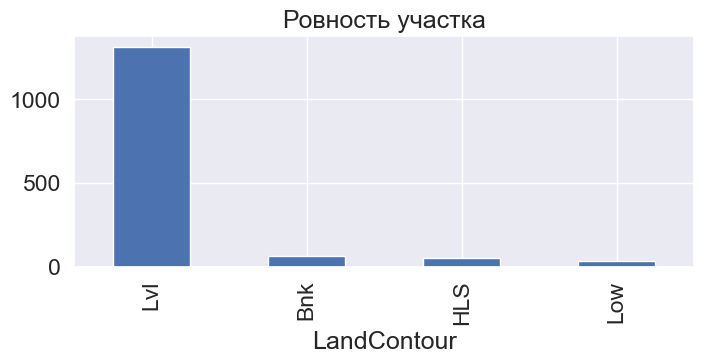

LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64

In [6]:
df1['LandContour'].value_counts().plot(kind='bar',figsize=(8,3), 
                                       title='Ровность участка');
plt.show()
df1['LandContour'].value_counts()

Значительное количество категории 'Lvl'- почти плоский/плоский. 

#### 2. GarageYrBlt

Выведем гистограмму распределения года постройки гаражей

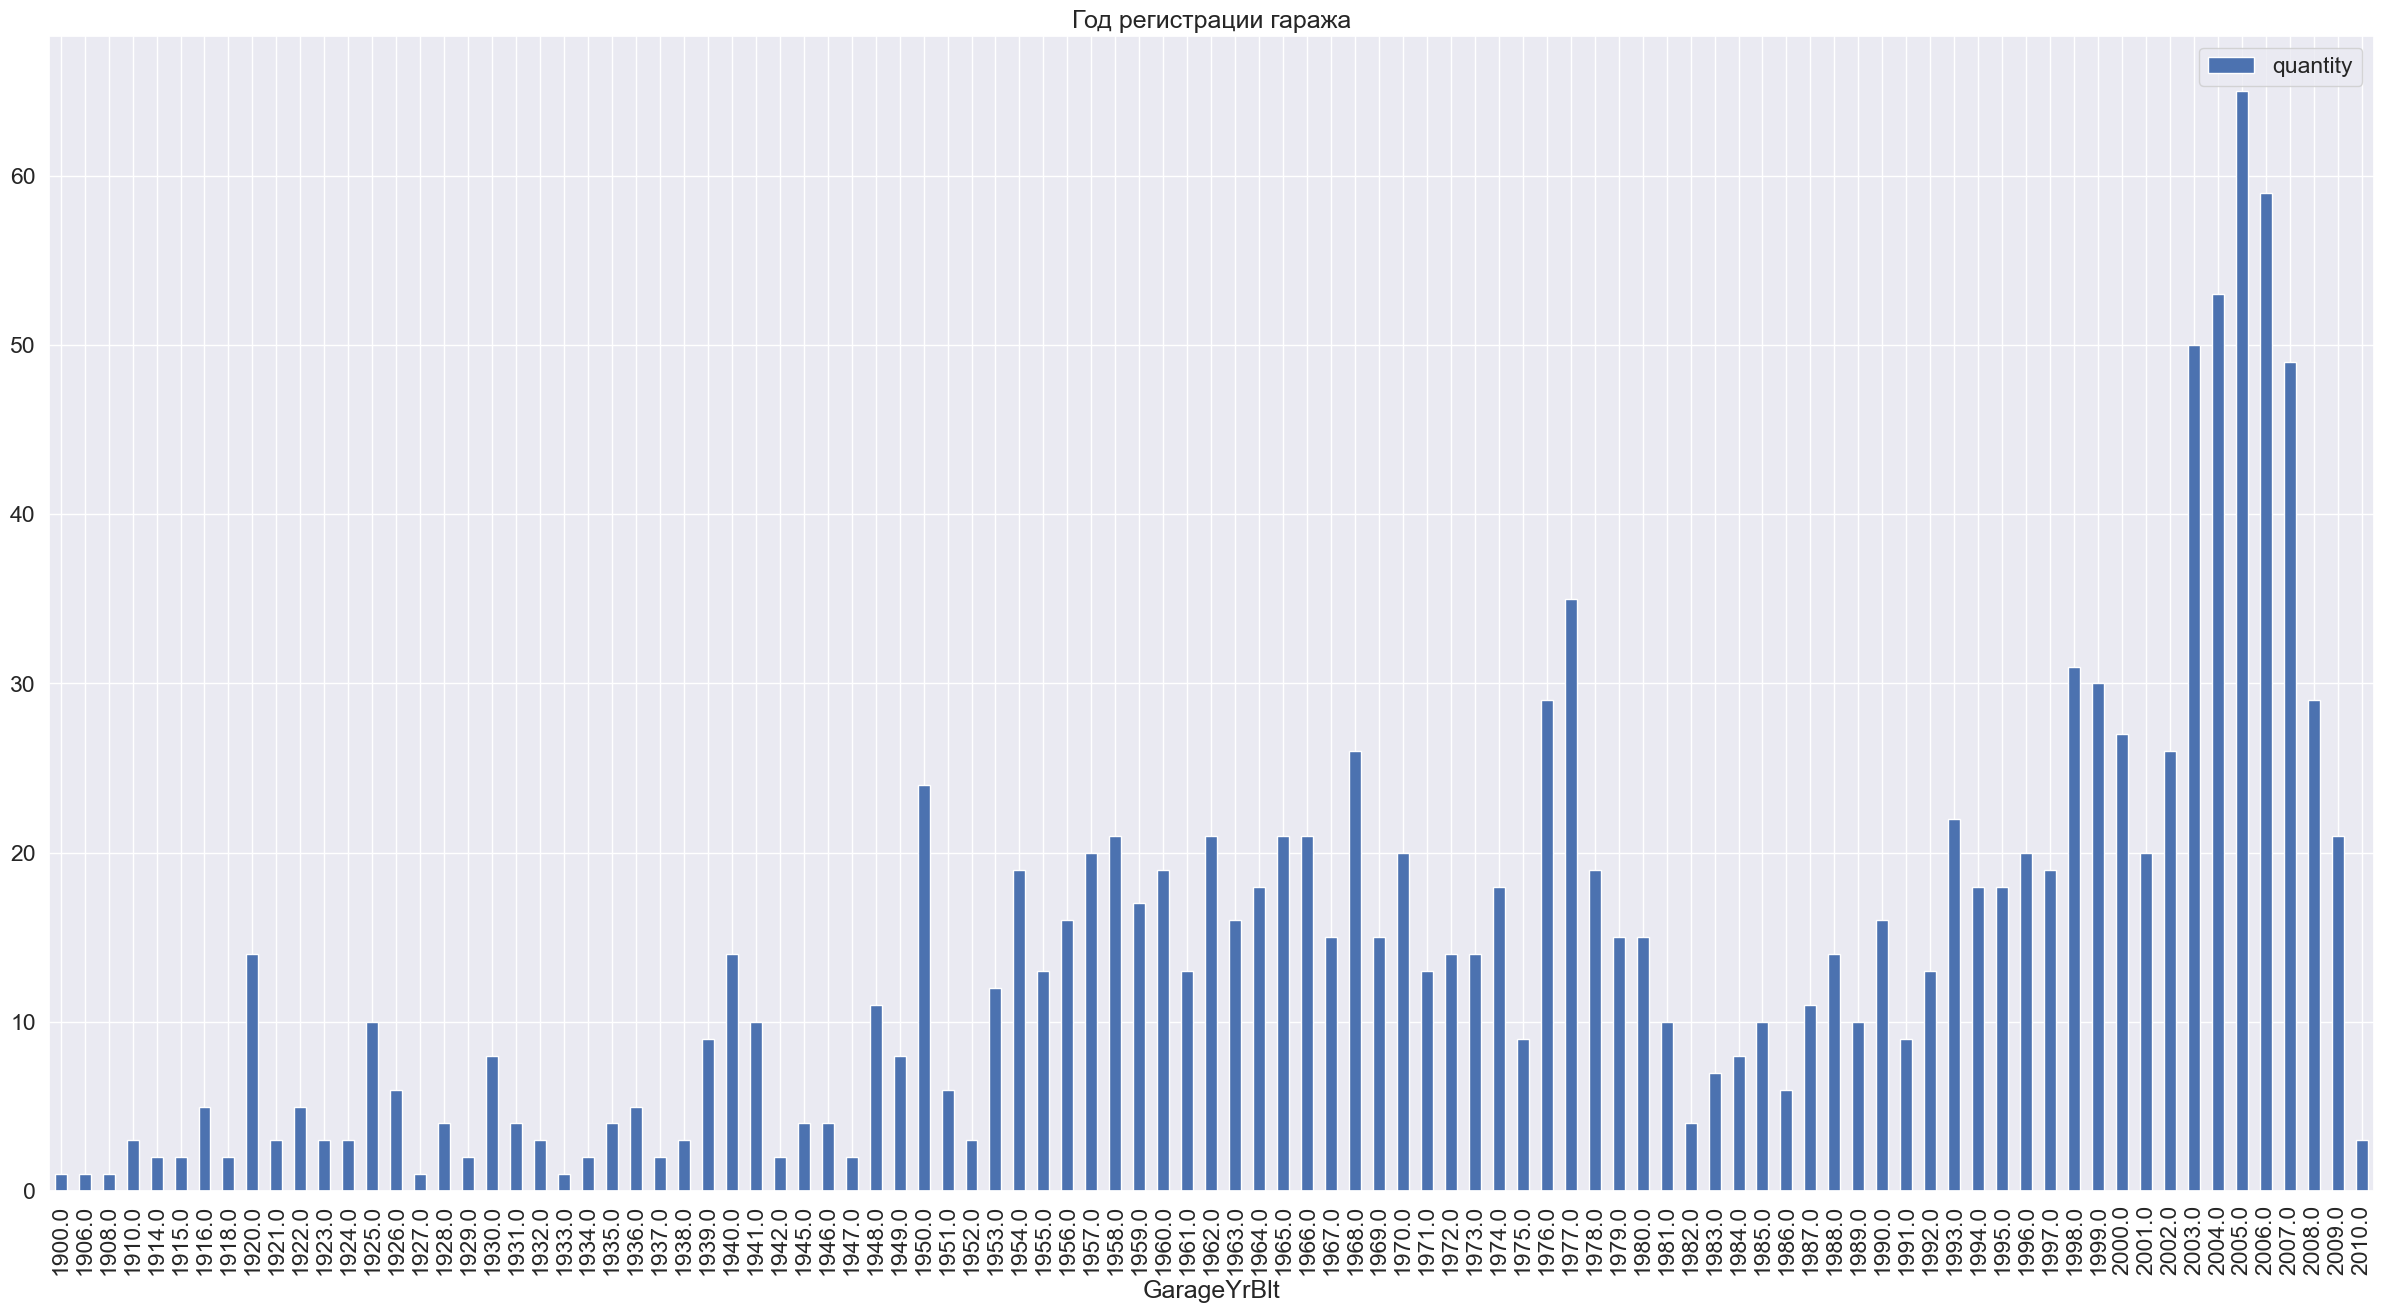

In [7]:
year = df1.pivot_table(index='GarageYrBlt', values='SalePrice', aggfunc='count')
year.columns = ['quantity']
year.plot.bar(figsize = (30,15))
plt.title('Год регистрации гаража')
plt.show()

Выведем жильё без гаража.

In [8]:
df1.query('GarageCars == 0')

,LandContour,GarageYrBlt,FullBath,1stFlrSF,BsmtFinSF1,TotRmsAbvGrd,ExterQual,OpenPorchSF,Heating,Condition2,OverallQual,GarageCars,KitchenQual,KitchenAbvGr,GrLivArea,2ndFlrSF,CentralAir,BsmtQual,TotalBsmtSF,Fireplaces,SalePrice
39,Lvl,NaN,2,1152,0,6,TA,0,GasA,Norm,4,0,Fa,2,1152,0,N,NaN,0,0,82000
48,Lvl,NaN,2,736,0,8,TA,0,GasA,Norm,4,0,TA,3,1452,716,Y,TA,736,0,113000
78,Lvl,NaN,2,1768,0,8,TA,0,GasA,Norm,4,0,TA,2,1768,0,N,TA,1768,0,136500
88,Lvl,NaN,1,1013,0,6,Fa,0,GasA,Feedr,3,0,Fa,1,1526,0,N,TA,1013,0,85000
89,Lvl,NaN,1,990,588,5,TA,0,GasA,Norm,4,0,TA,1,990,0,Y,Gd,990,0,123600
99,Lvl,NaN,1,1225,569,6,TA,0,GasA,Norm,4,0,TA,1,1225,0,Y,TA,950,0,128950
108,Lvl,NaN,2,997,0,7,TA,0,GasW,Norm,5,0,Fa,1,1517,520,N,TA,793,0,115000
125,Lvl,NaN,1,520,490,5,TA,0,GasA,Norm,6,0,TA,1,754,0,N,TA,520,0,84500
127,Bnk,NaN,1,840,116,5,TA,0,GasA,Norm,5,0,TA,1,840,0,Y,TA,672,1,87000
140,Lvl,NaN,1,864,432,5,TA,0,GasA,Norm,4,0,TA,1,864,0,Y,TA,864,1,115000


Распределение в диапазоне от 1900 до 2010 года. Гистограмма волнообразна, с значительным ростом постройки с 2000-х. Много значений малочисленных (в том числе единичных). Пропуски означают, что нет гаража. После эксперимента и анализа метрики, принято решение удалить объекты с пропусками.

In [9]:
df1 = df1.dropna(subset=['GarageYrBlt']).reset_index(drop=True)

#### 3. FullBath

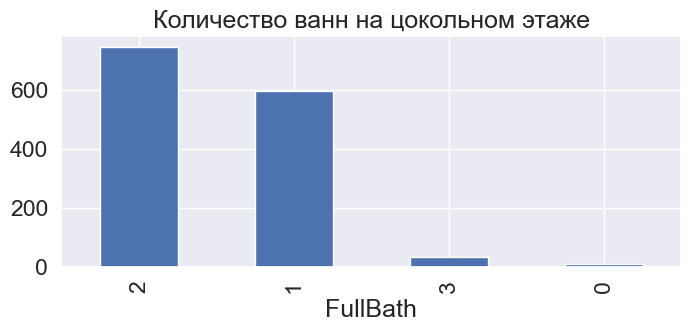

FullBath
2    746
1    594
3     31
0      8
Name: count, dtype: int64

In [10]:
df1['FullBath'].value_counts().plot(kind='bar',figsize=(8,3), 
                                       title='Количество ванн на цокольном этаже');
plt.show()
df1['FullBath'].value_counts()

Есть варианты без ванн, в этом сегменте жилья превалирует вариант с 2-мя ванным комнатами. 

#### 4. 1stFlrSF

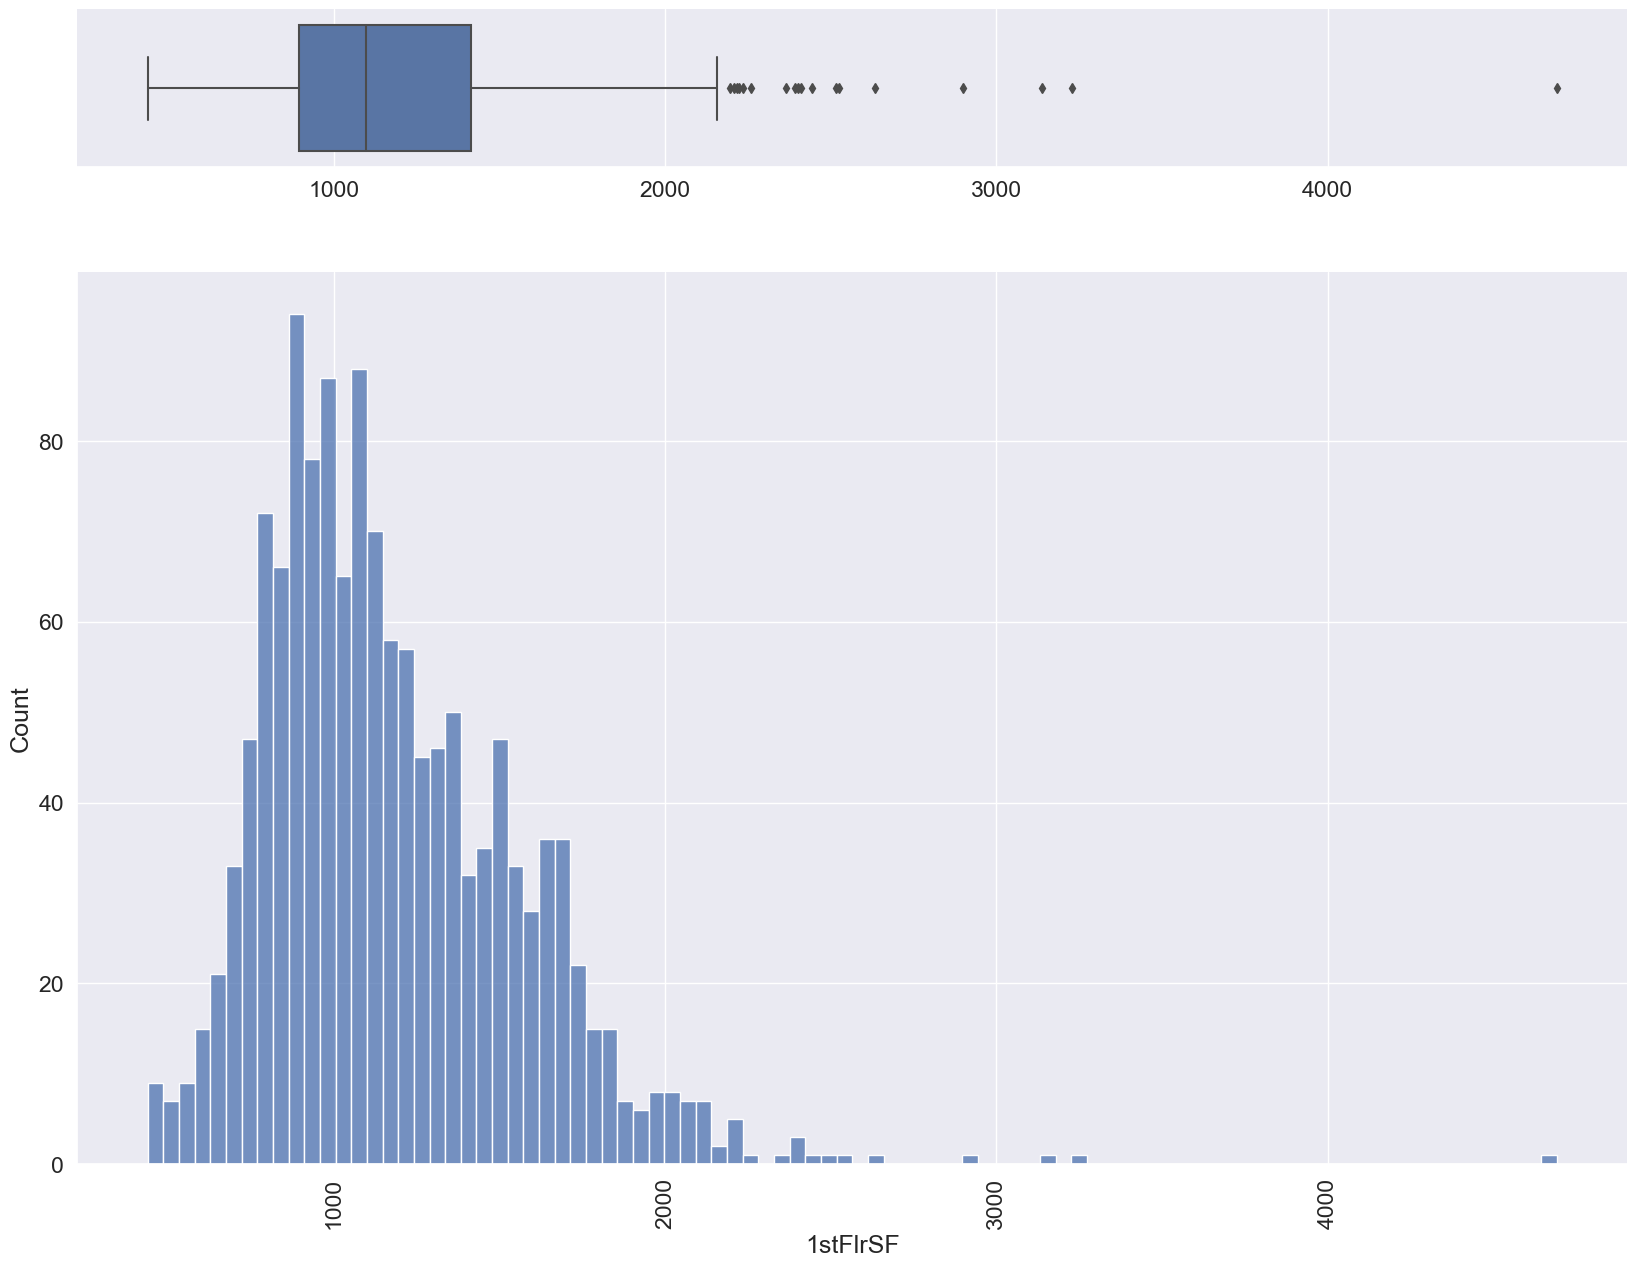

In [11]:
# выводим распределение площади первого этажа в квадратных футах
f,(ax_1, ax_2) = plt.subplots(2, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(20,15)) 
sns.boxplot(x=df1['1stFlrSF'], ax=ax_1) 
sns.histplot(x=df1['1stFlrSF'], ax=ax_2, bins=90)
ax_1.set(yticks=[], xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2) 
ax_2.tick_params(axis= 'x', labelrotation=90)

In [12]:
df1['1stFlrSF'].describe()

count    1379.000000
mean     1177.129804
std       387.014961
min       438.000000
25%       894.000000
50%      1098.000000
75%      1414.000000
max      4692.000000
Name: 1stFlrSF, dtype: float64

Распределение нормальное от 334 до 4692 квадратных фута, минимальное и максимальное значение реалистично.

#### 5. BsmtFinSF1	

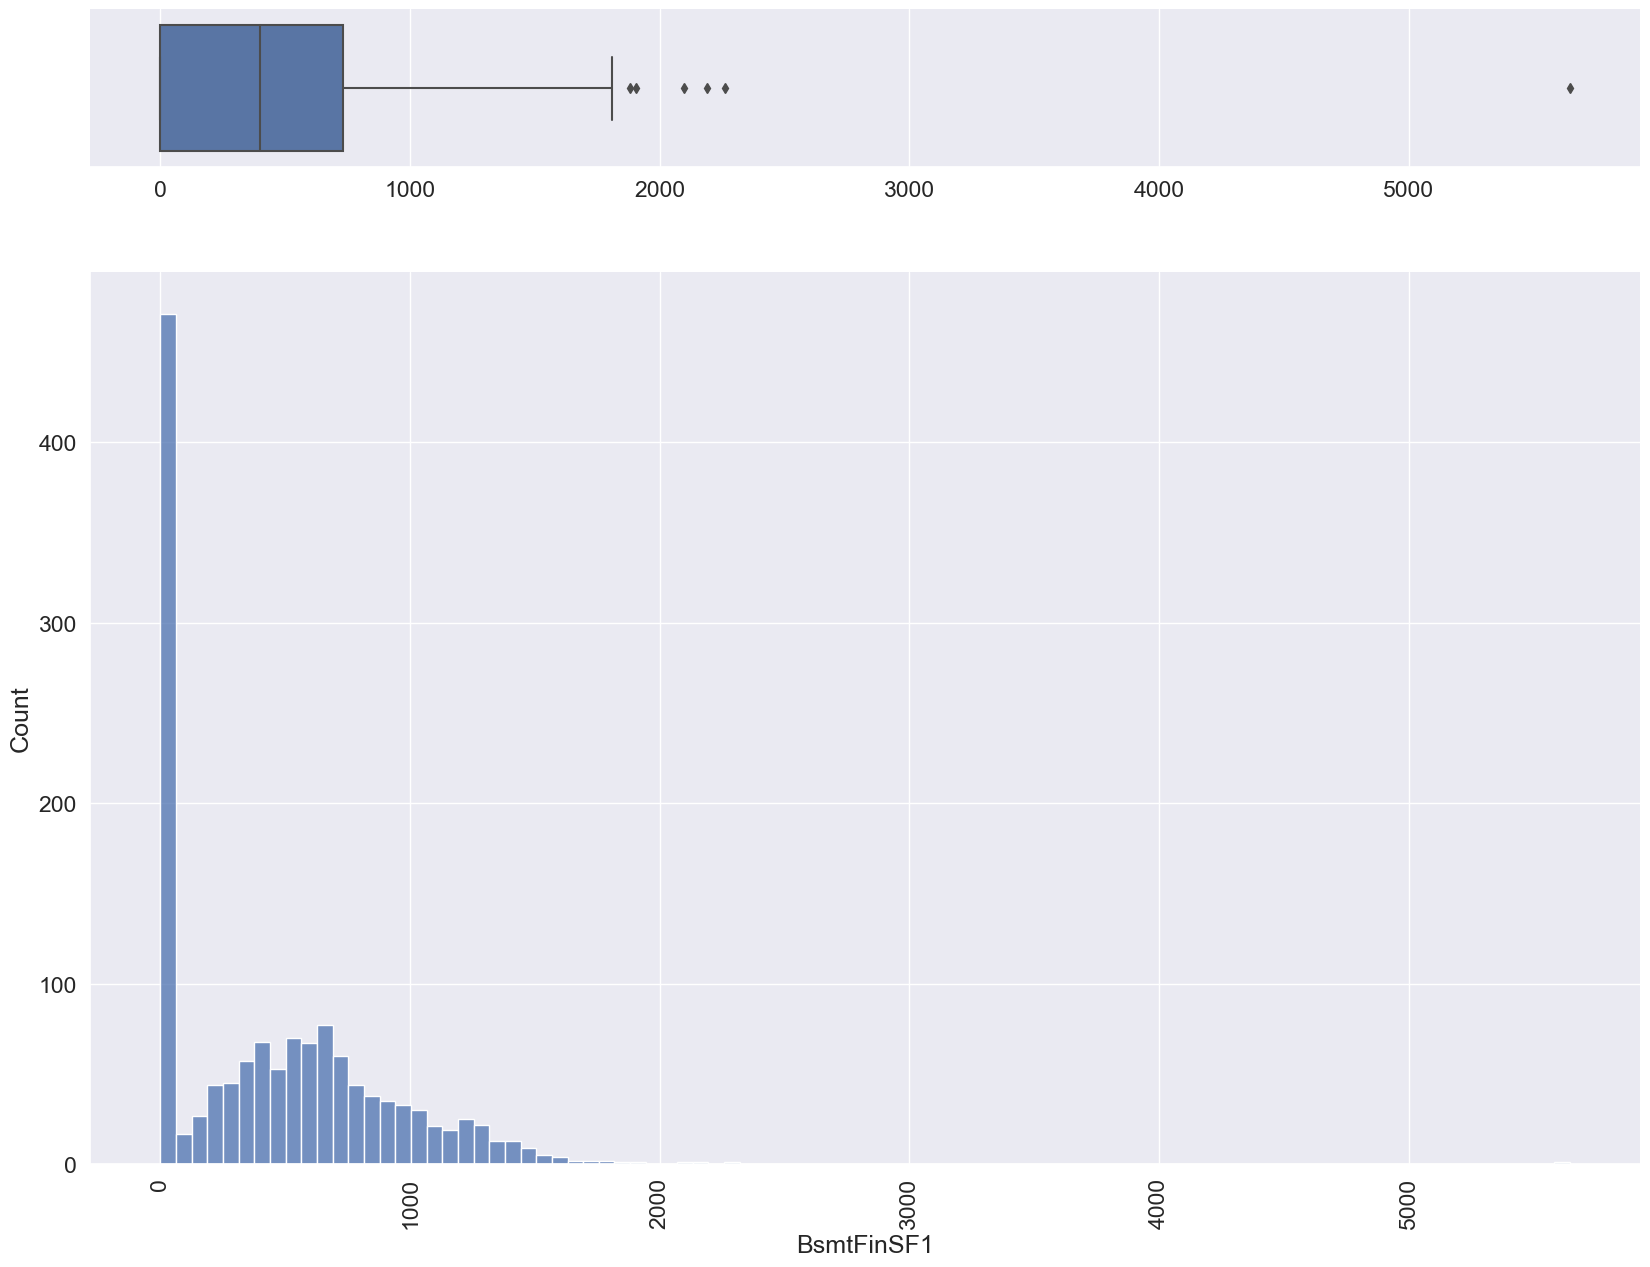

In [13]:
# выводим распределение готовой площади типа 1 в квадратных футах
f,(ax_1, ax_2) = plt.subplots(2, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(20,15)) 
sns.boxplot(x=df1['BsmtFinSF1'], ax=ax_1) 
sns.histplot(x=df1['BsmtFinSF1'], ax=ax_2, bins=90)
ax_1.set(yticks=[], xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2) 
ax_2.tick_params(axis= 'x', labelrotation=90)

In [14]:
df1['BsmtFinSF1'].describe()

count    1379.000000
mean      455.578680
std       459.691379
min         0.000000
25%         0.000000
50%       400.000000
75%       732.000000
max      5644.000000
Name: BsmtFinSF1, dtype: float64

In [15]:
df1.query('BsmtFinSF1 > 4000')['1stFlrSF'].value_counts()

1stFlrSF
4692    1
Name: count, dtype: int64

Много нулевых значений. Выброс 5644 относится к объекту с площадью первого этажа 4692 квадратных футов. Интересно будет увидить клрреляцию с целевым признаком.

#### 6. TotRmsAbvGrd	

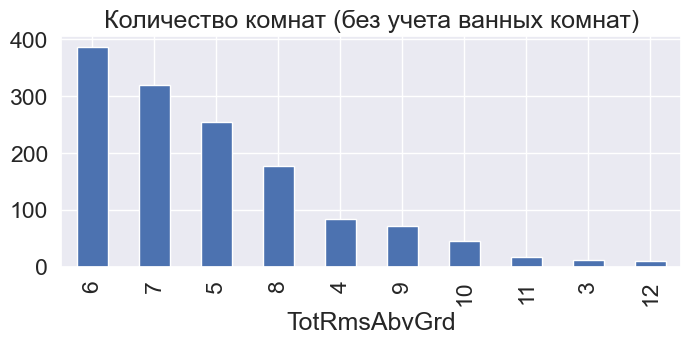

TotRmsAbvGrd
6     387
7     320
5     254
8     177
4      84
9      72
10     45
11     18
3      12
12     10
Name: count, dtype: int64

In [16]:
df1['TotRmsAbvGrd'].value_counts().plot(kind='bar',figsize=(8,3), 
                                       title='Количество комнат (без учета ванных комнат)');
plt.show()
df1['TotRmsAbvGrd'].value_counts()

Уберем единичные случаи.

In [17]:
df1 = df1.query('TotRmsAbvGrd != 2 & TotRmsAbvGrd != 14')

#### 7. ExterQual	

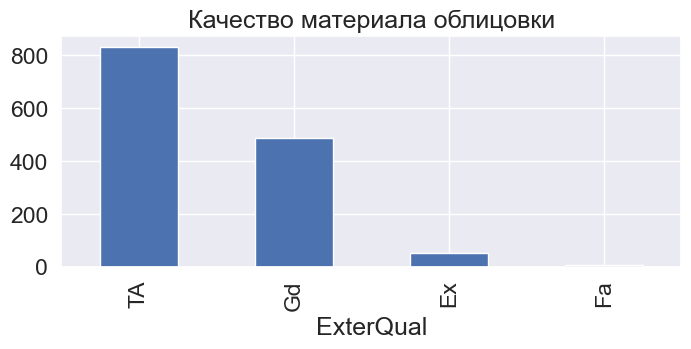

ExterQual
TA    833
Gd    487
Ex     52
Fa      7
Name: count, dtype: int64

In [18]:
df1['ExterQual'].value_counts().plot(kind='bar',figsize=(8,3), 
                                       title='Качество материала облицовки');
plt.show()
df1['ExterQual'].value_counts()

В основном облицовка хорошего качества, объектов с плохим качеством нет.

#### 8. OpenPorchSF

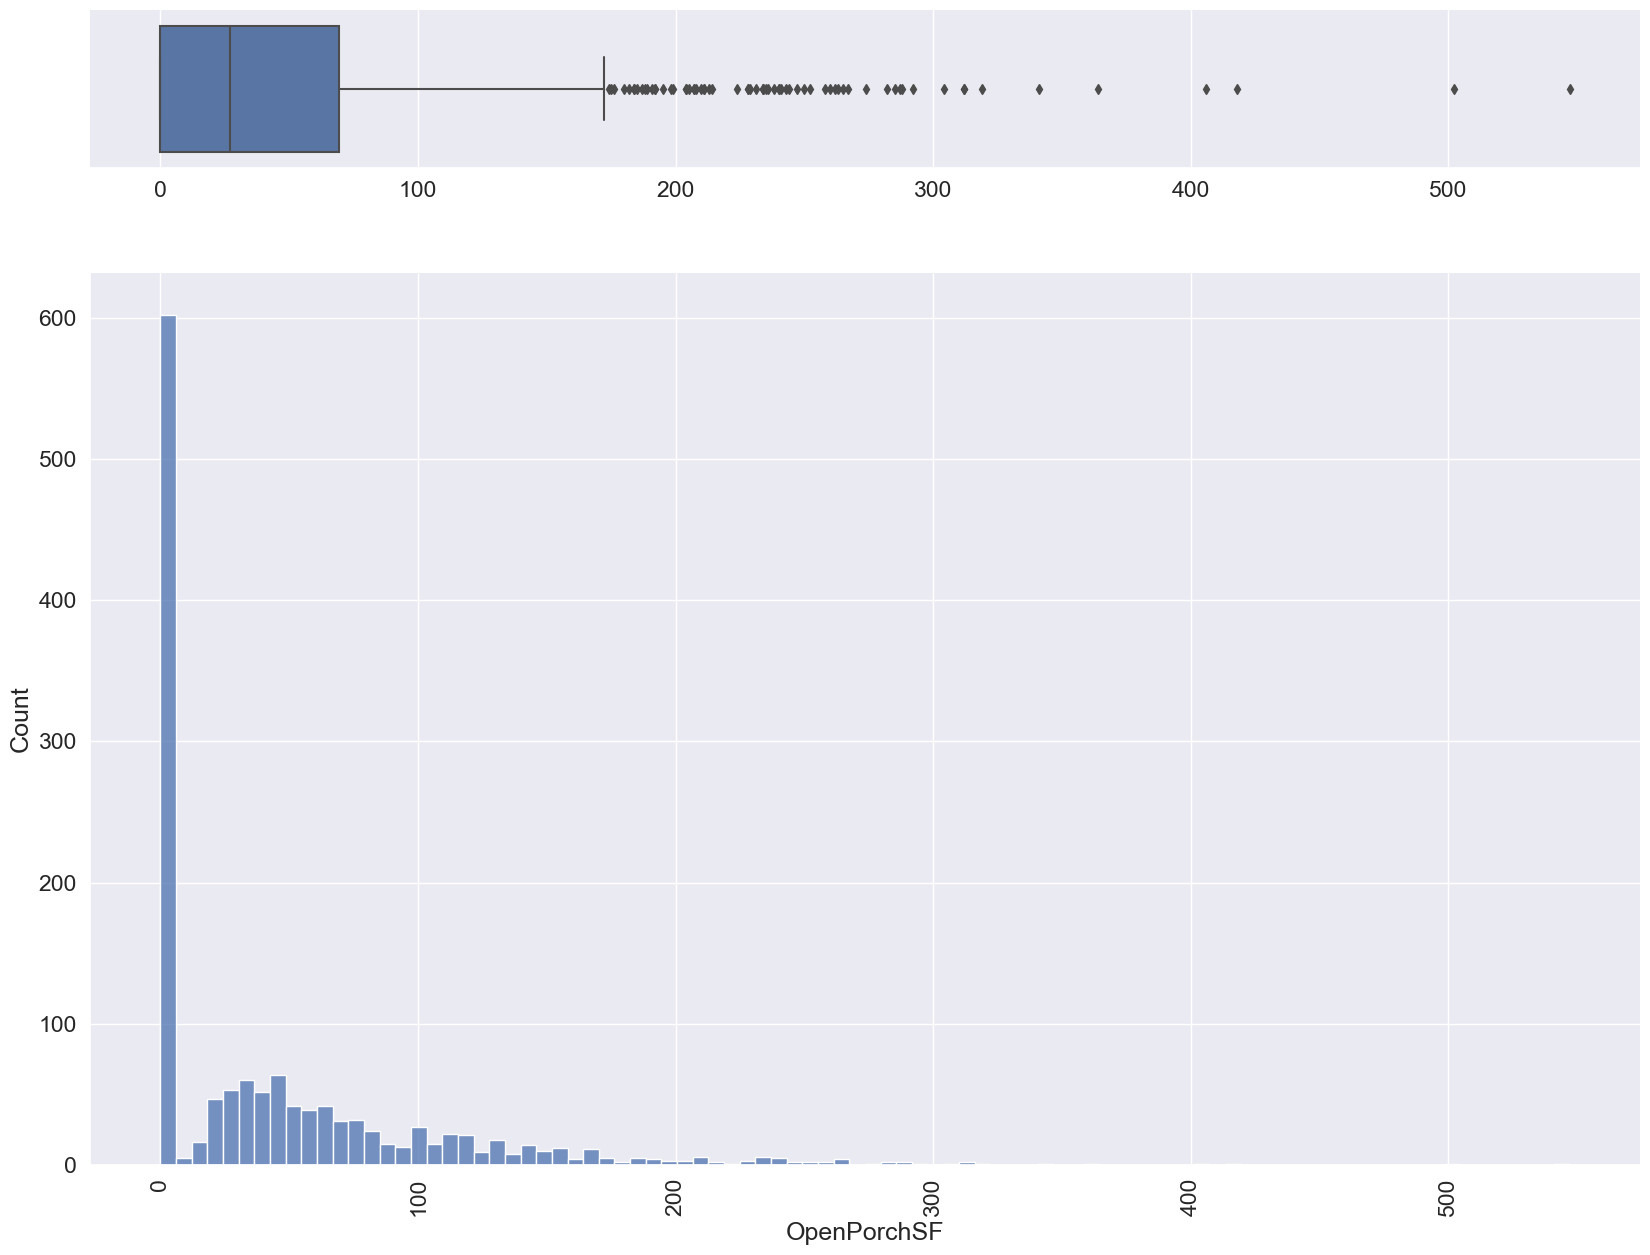

In [19]:
# выводим распределение площади открытой веранды в квадратных футах
f,(ax_1, ax_2) = plt.subplots(2, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(20,15)) 
sns.boxplot(x=df1['OpenPorchSF'], ax=ax_1) 
sns.histplot(x=df1['OpenPorchSF'], ax=ax_2, bins=90)
ax_1.set(yticks=[], xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2) 
ax_2.tick_params(axis= 'x', labelrotation=90)

In [20]:
df1['OpenPorchSF'].describe()

count    1379.000000
mean       47.276287
std        65.210465
min         0.000000
25%         0.000000
50%        27.000000
75%        69.500000
max       547.000000
Name: OpenPorchSF, dtype: float64

Много нулевых значений, что означает отсутствие открытой веранды.

#### 9. Heating

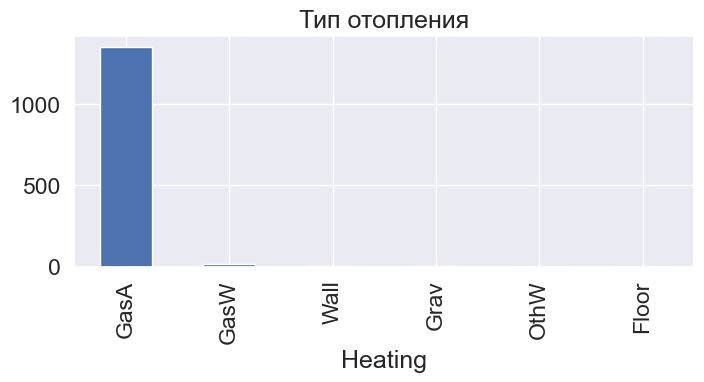

Heating
GasA     1353
GasW       17
Wall        4
Grav        3
OthW        1
Floor       1
Name: count, dtype: int64

In [21]:
df1['Heating'].value_counts().plot(kind='bar',figsize=(8,3), 
                                       title='Тип отопления');
plt.show()
df1['Heating'].value_counts()

Превалирует отопление газовой печью с с принудительным нагревом теплого воздуха, уберем малочисленные категории.

In [22]:
df1 = df1.query('Heating != "Floor"  & Heating != "OthW" & Heating != "Wall" & Heating != "Grav"')

#### 10. Condition2

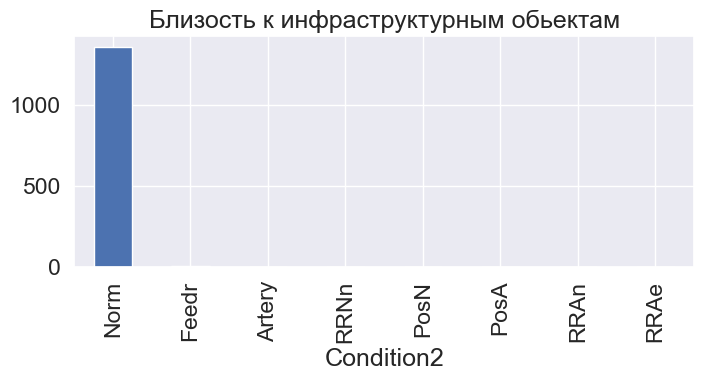

Condition2
Norm      1356
Feedr        5
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: count, dtype: int64

In [23]:
df1['Condition2'].value_counts().plot(kind='bar',figsize=(8,3), 
                                       title='Близость к инфраструктурным обьектам');
plt.show()
df1['Condition2'].value_counts()

Резкий дисбаланс в пользу одной категории, посмотрим корреляцию с целевым признаком. Уберем единичные случаи.

In [24]:
df1 = df1.query('Condition2 != "RRAe"  & Condition2 != "RRAn" & Condition2 != "PosA"')

#### 11. OverallQual

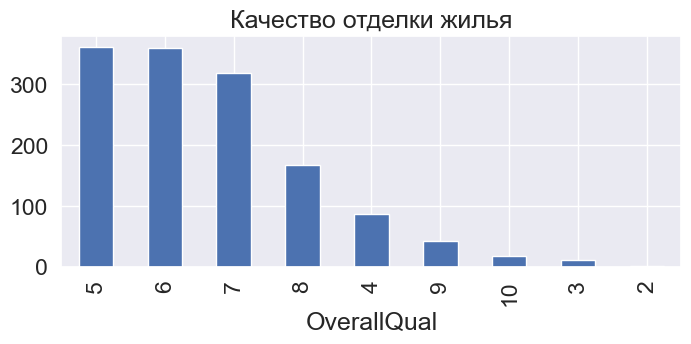

OverallQual
5     362
6     360
7     318
8     167
4      87
9      43
10     17
3      11
2       2
Name: count, dtype: int64

In [25]:
df1['OverallQual'].value_counts().plot(kind='bar',figsize=(8,3), 
                                       title='Качество отделки жилья');
plt.show()
df1['OverallQual'].value_counts()

Есть единичные объекты с плохим качеством отделки, уберем их. 

In [26]:
df1 = df1.query('OverallQual != 1 & OverallQual != 2')

#### 12. GarageCars

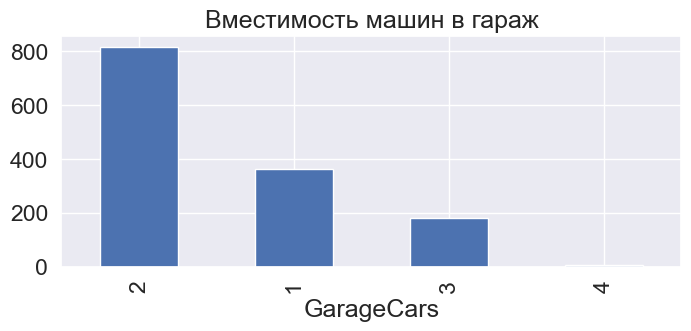

GarageCars
2    817
1    362
3    181
4      5
Name: count, dtype: int64

In [27]:
df1['GarageCars'].value_counts().plot(kind='bar',figsize=(8,3), 
                                       title='Вместимость машин в гараж');
plt.show()
df1['GarageCars'].value_counts()

В данном сегменте большинство жилья с двумя гаражами, уберем малочисленную группу.

In [28]:
df1 = df1.query('GarageCars != 4')

#### 13. KitchenQual

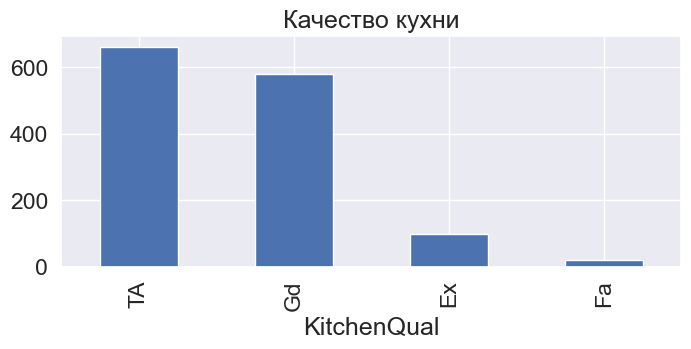

KitchenQual
TA    662
Gd    579
Ex     98
Fa     21
Name: count, dtype: int64

In [29]:
df1['KitchenQual'].value_counts().plot(kind='bar',figsize=(8,3), 
                                       title='Качество кухни');
plt.show()
df1['KitchenQual'].value_counts()


В основном кухни с хорошим ремонтом, с плохим нет.

#### 14. KitchenAbvGr

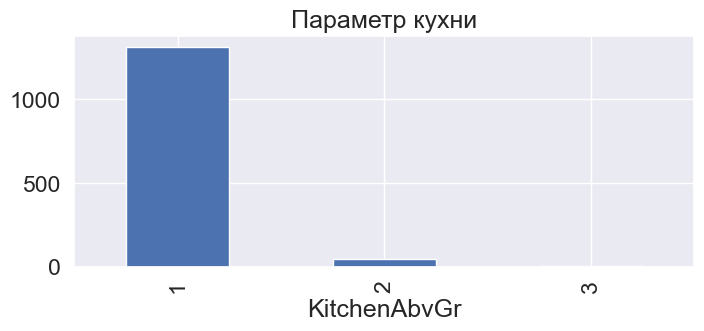

KitchenAbvGr
1    1315
2      44
3       1
Name: count, dtype: int64

In [30]:
df1['KitchenAbvGr'].value_counts().plot(kind='bar',figsize=(8,3), 
                                       title='Параметр кухни');
plt.show()
df1['KitchenAbvGr'].value_counts()

Данного признака нет в описании данных, посмотрим корреляцию с целевым признаком. Уберем единичные категории.

In [31]:
df1 = df1.query('KitchenAbvGr != 0 & KitchenAbvGr != 3')

#### 15. GrLivArea

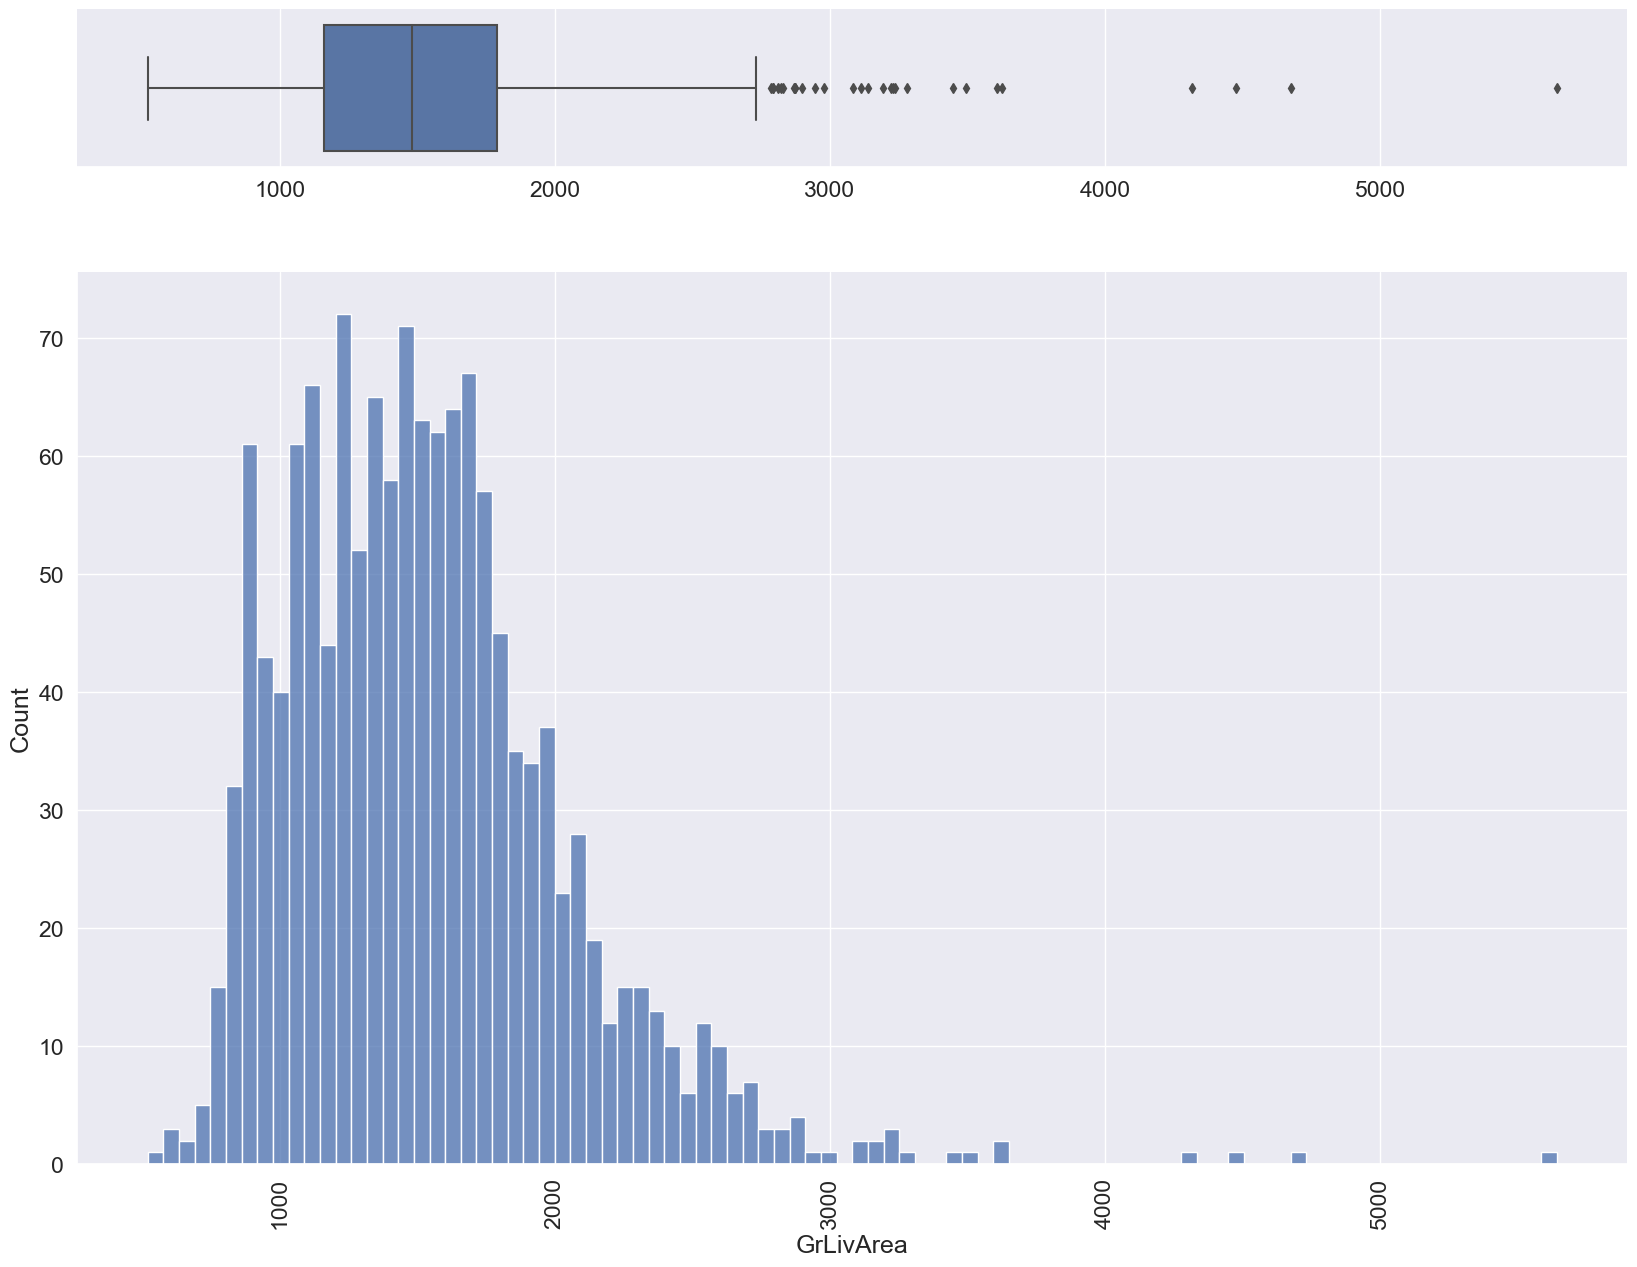

In [32]:
# выводим распределение жилой площади надземной части в квадратных футах
f,(ax_1, ax_2) = plt.subplots(2, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(20,15)) 
sns.boxplot(x=df1['GrLivArea'], ax=ax_1) 
sns.histplot(x=df1['GrLivArea'], ax=ax_2, bins=90)
ax_1.set(yticks=[], xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2) 
ax_2.tick_params(axis= 'x', labelrotation=90)

In [33]:
df1['GrLivArea'].describe()

count    1359.000000
mean     1535.689478
std       514.952440
min       520.000000
25%      1161.000000
50%      1479.000000
75%      1789.000000
max      5642.000000
Name: GrLivArea, dtype: float64

Распределение нормальное, сопаставимо с другими площадными признаками. Уберем выбросы.

In [34]:
df1 = df1.query('GrLivArea > 700 & GrLivArea < 3000')

#### 16. 2ndFlrSF

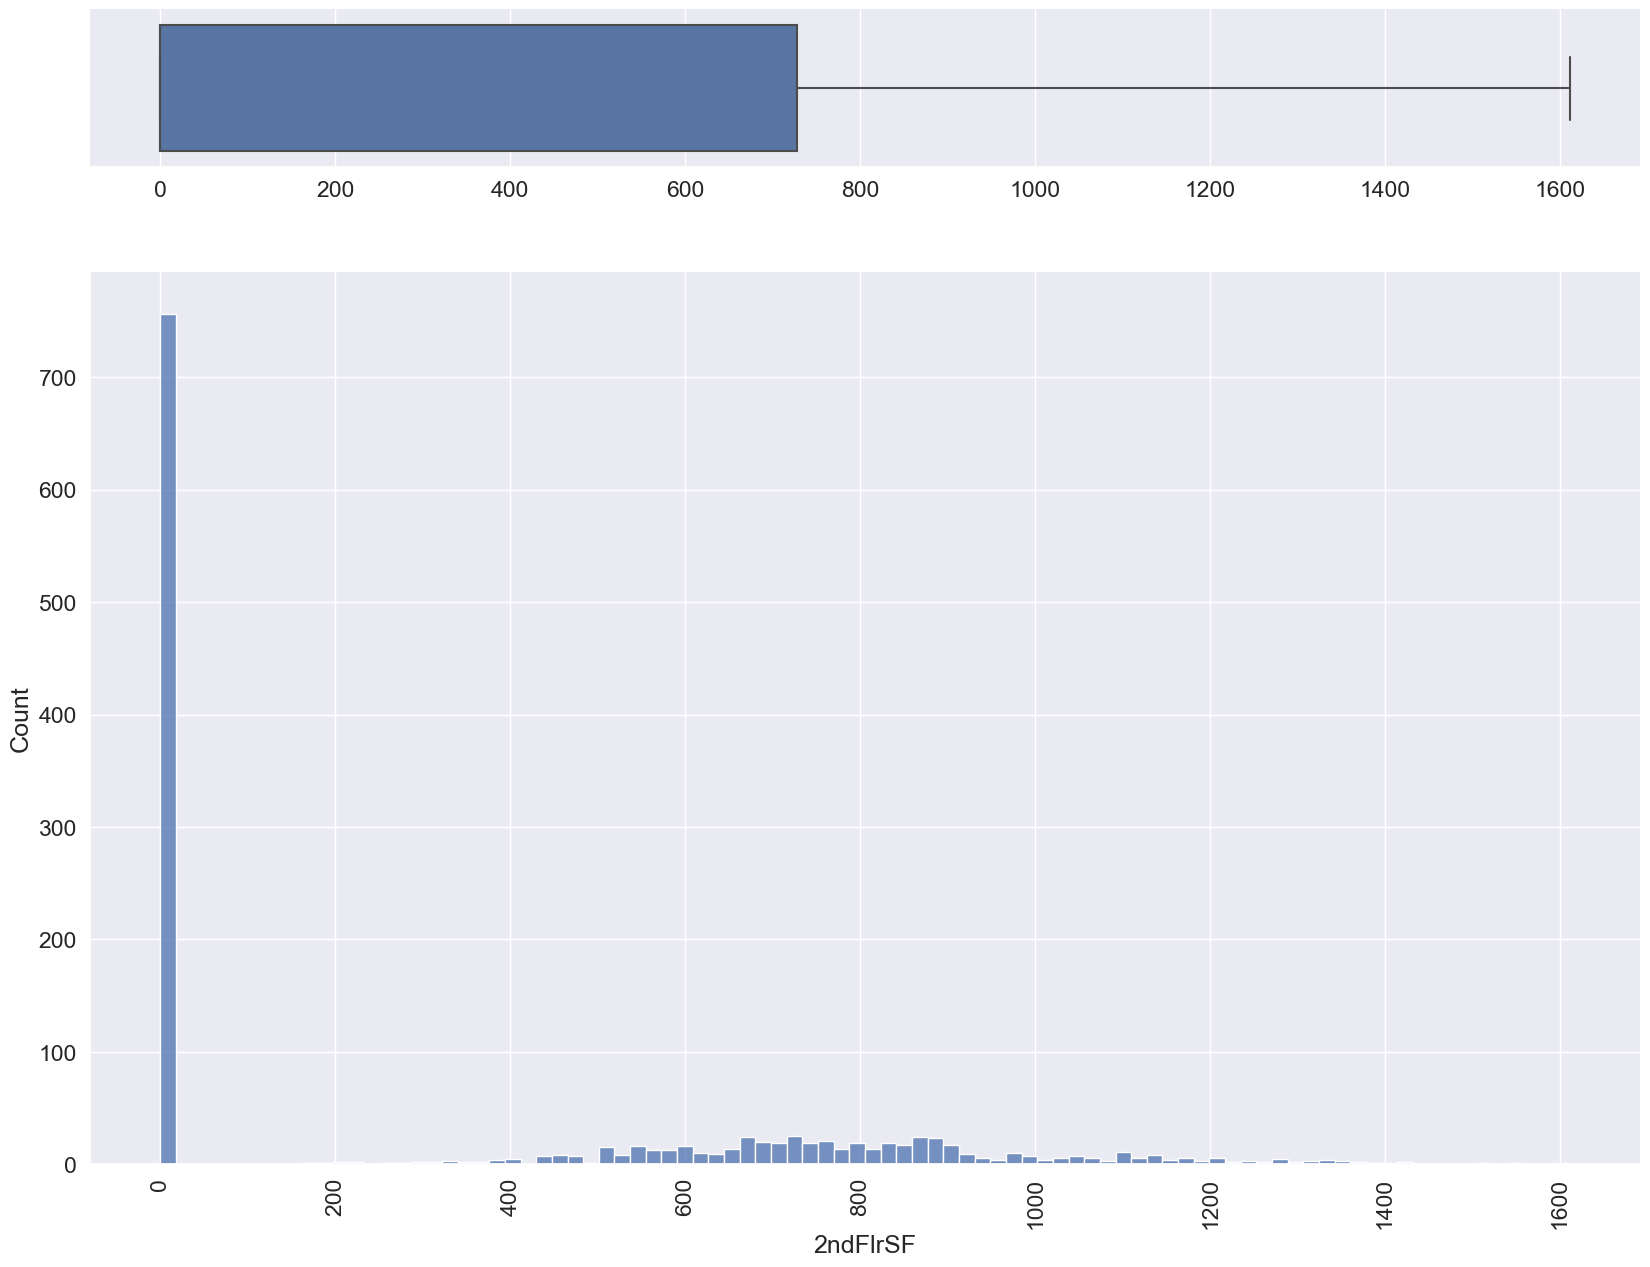

In [35]:
# выводим распределение площади второго этажа в квадратных футах
f,(ax_1, ax_2) = plt.subplots(2, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(20,15)) 
sns.boxplot(x=df1['2ndFlrSF'], ax=ax_1) 
sns.histplot(x=df1['2ndFlrSF'], ax=ax_2, bins=90)
ax_1.set(yticks=[], xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2) 
ax_2.tick_params(axis= 'x', labelrotation=90)

In [36]:
df1['2ndFlrSF'].describe()

count    1335.000000
mean      342.655431
std       423.111842
min         0.000000
25%         0.000000
50%         0.000000
75%       728.000000
max      1611.000000
Name: 2ndFlrSF, dtype: float64

Большая часть одноэтажное жилье.

#### 17. CentralAir

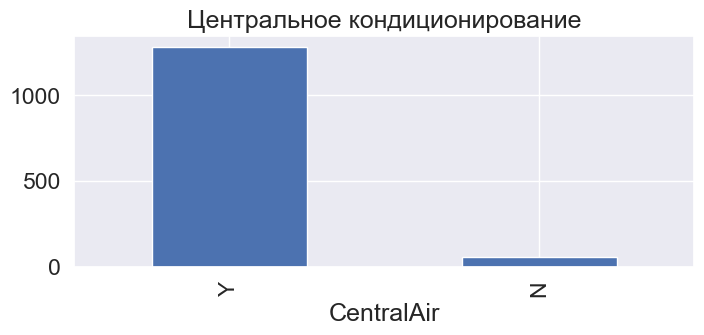

CentralAir
Y    1281
N      54
Name: count, dtype: int64

In [37]:
df1['CentralAir'].value_counts().plot(kind='bar',figsize=(8,3), 
                                       title='Центральное кондиционирование');
plt.show()
df1['CentralAir'].value_counts()

Почти все жилье с центральным кондицирнированием.

#### 18. TotalBsmtSF

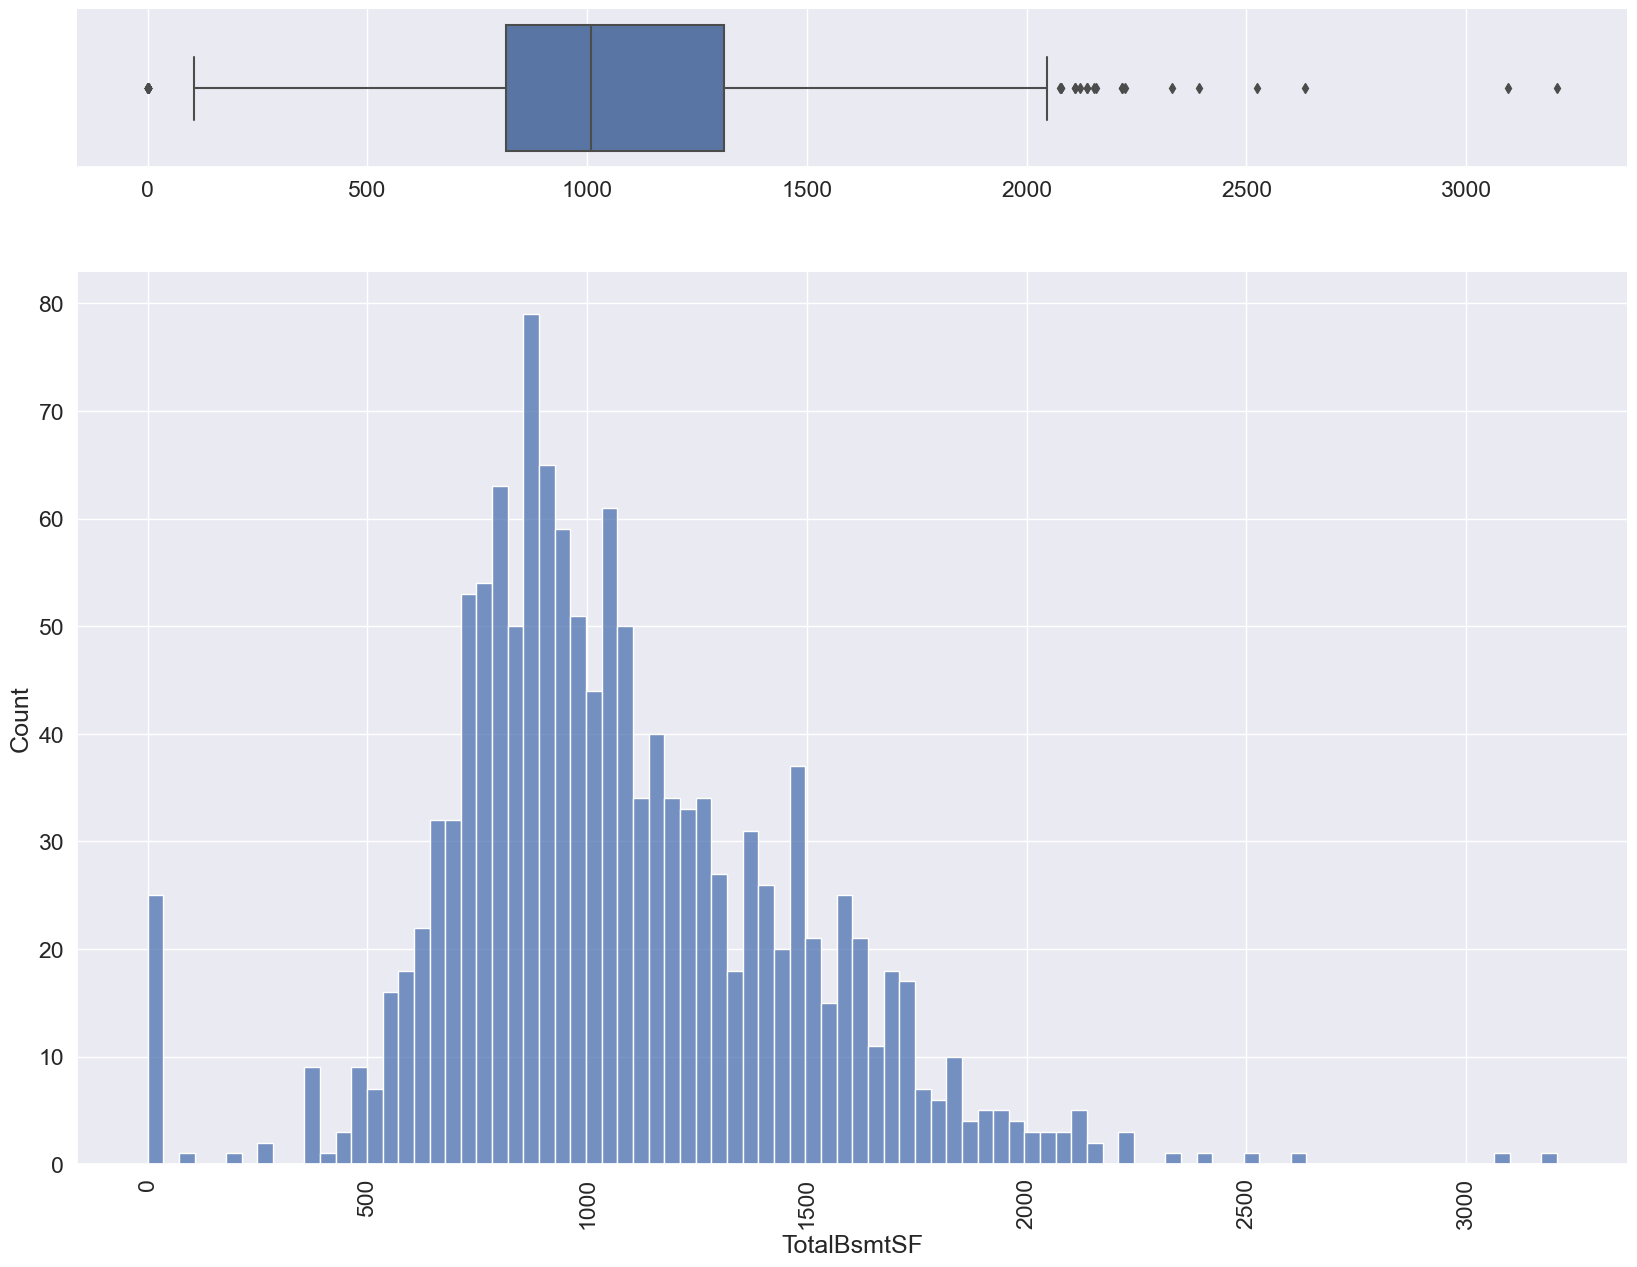

In [38]:
# выводим распределение площади подвала в квадратных футах
f,(ax_1, ax_2) = plt.subplots(2, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(20,15)) 
sns.boxplot(x=df1['TotalBsmtSF'], ax=ax_1) 
sns.histplot(x=df1['TotalBsmtSF'], ax=ax_2, bins=90)
ax_1.set(yticks=[], xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2) 
ax_2.tick_params(axis= 'x', labelrotation=90)

In [39]:
df1['TotalBsmtSF'].describe()

count    1335.000000
mean     1070.316854
std       398.154863
min         0.000000
25%       816.000000
50%      1008.000000
75%      1310.500000
max      3206.000000
Name: TotalBsmtSF, dtype: float64

Нулевые позиции, как раз соотвествуют пропускам в признаке высоты потолка подвала.

#### 19. BsmtQual

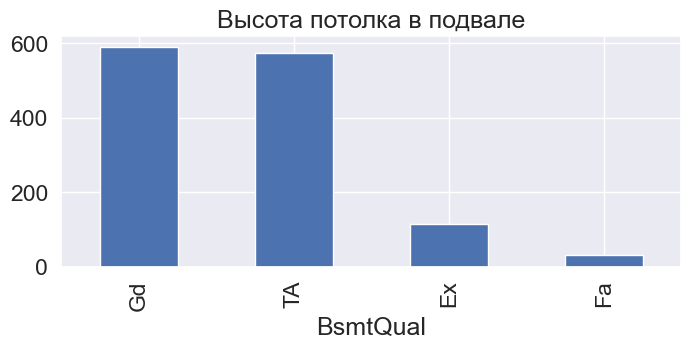

BsmtQual
Gd    590
TA    574
Ex    115
Fa     31
Name: count, dtype: int64

In [40]:
df1['BsmtQual'].value_counts().plot(kind='bar',figsize=(8,3), 
                                       title='Высота потолка в подвале');
plt.show()
df1['BsmtQual'].value_counts()

По описанию данных заполним пропуски "NA" - нет подвала.

In [41]:
df1['BsmtQual'].fillna('NA', inplace=True)

#### 20. Fireplaces

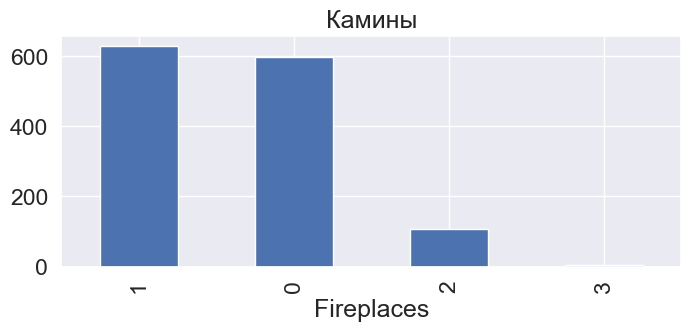

Fireplaces
1    628
0    597
2    106
3      4
Name: count, dtype: int64

In [42]:
df1['Fireplaces'].value_counts().plot(kind='bar',figsize=(8,3), 
                                       title='Камины');
plt.show()
df1['Fireplaces'].value_counts()

Оставим популярные категории с каминами.

In [43]:
df1 = df1.query('Fireplaces != 3')

#### 21. SalePrice

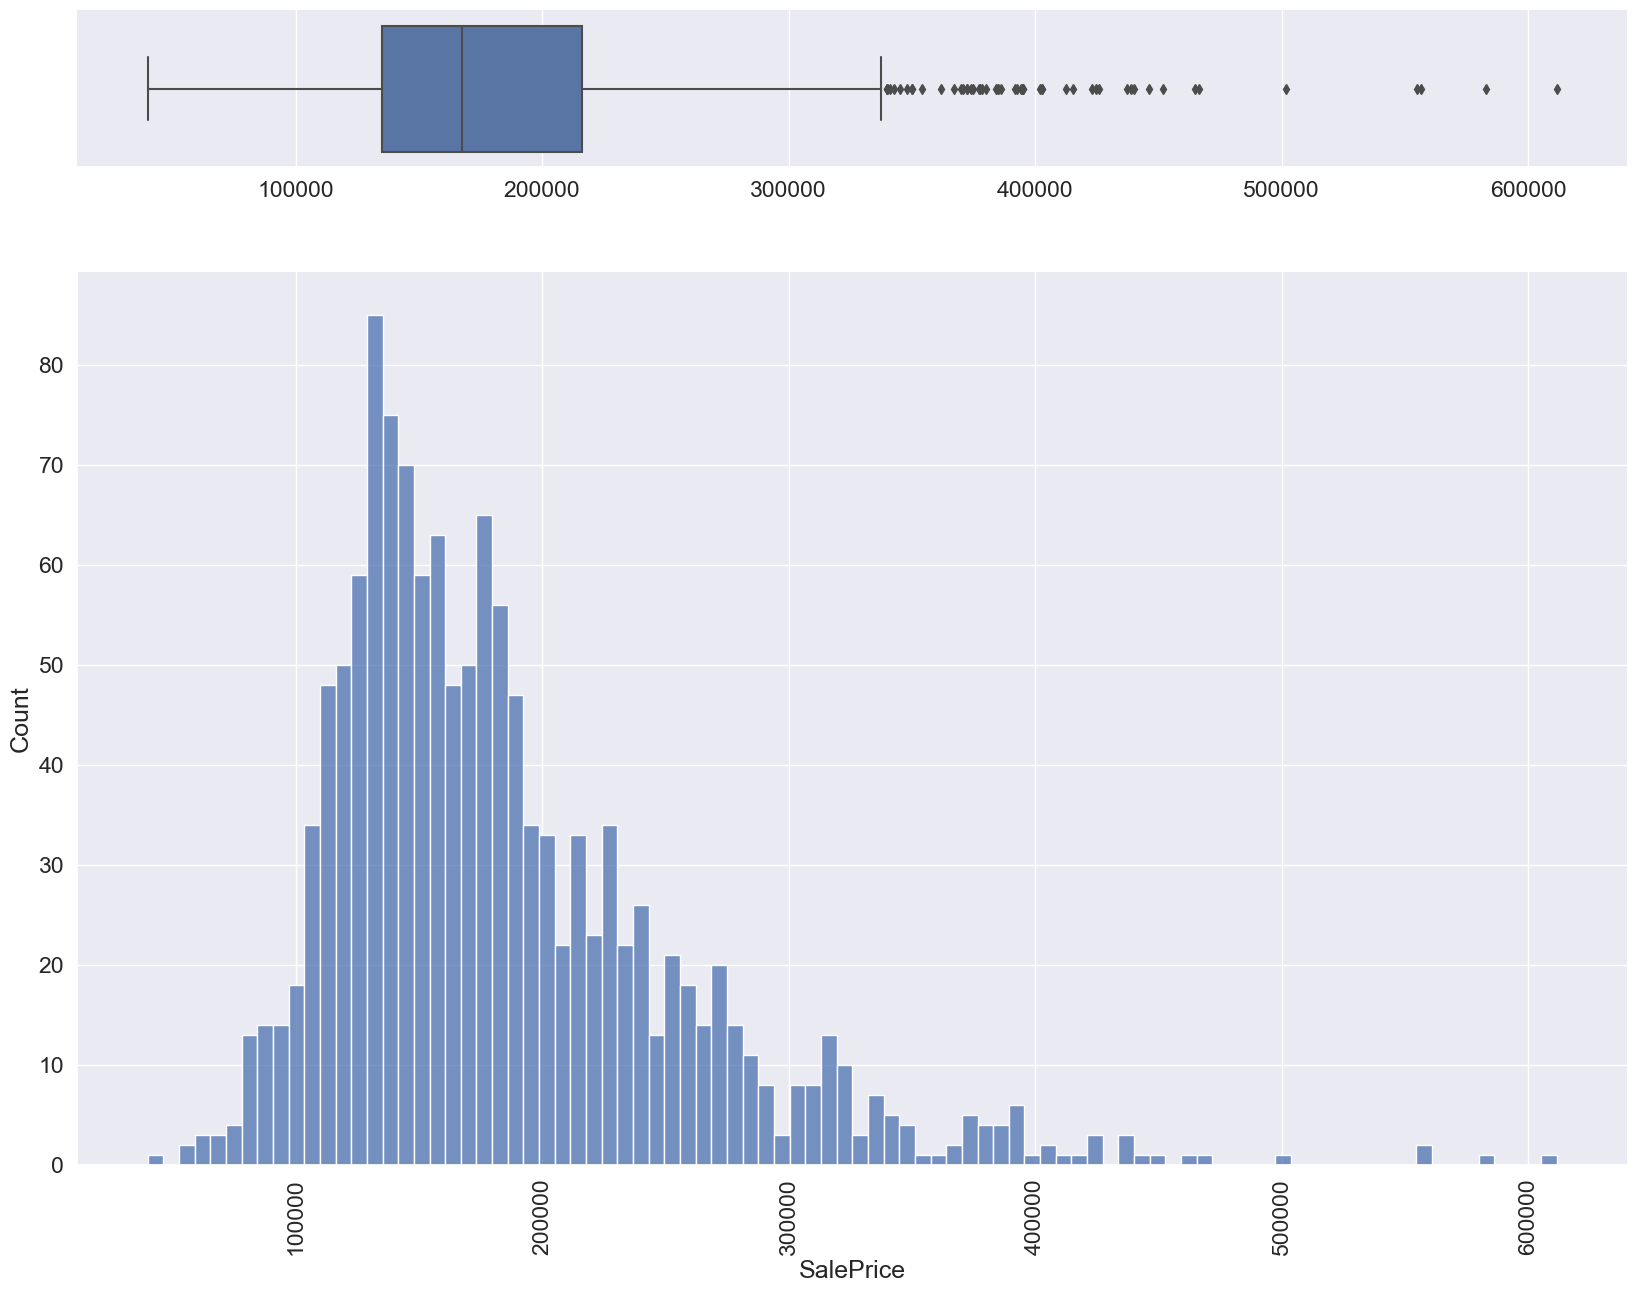

In [44]:
# выводим распределение цен за жильё
f,(ax_1, ax_2) = plt.subplots(2, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(20,15)) 
sns.boxplot(x=df1['SalePrice'], ax=ax_1) 
sns.histplot(x=df1['SalePrice'], ax=ax_2, bins=90)
ax_1.set(yticks=[], xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2) 
ax_2.tick_params(axis= 'x', labelrotation=90)

In [45]:
df1['SalePrice'].describe()

count      1331.000000
mean     183828.813674
std       72438.837808
min       40000.000000
25%      135000.000000
50%      167500.000000
75%      216250.000000
max      611657.000000
Name: SalePrice, dtype: float64

Цены распределены в диапазоне от 34,900 до 611,657$. Для лучшего обучения, уберем малочисленные объекты (чересчур дорогие и дешевые) 

In [46]:
df1 = df1.query('SalePrice > 70000 & SalePrice < 450000')

In [47]:
print('Количество пропусков после предобработки:')
display(df1.isna().sum())

Количество пропусков после предобработки:


LandContour     0
GarageYrBlt     0
FullBath        0
1stFlrSF        0
BsmtFinSF1      0
TotRmsAbvGrd    0
ExterQual       0
OpenPorchSF     0
Heating         0
Condition2      0
OverallQual     0
GarageCars      0
KitchenQual     0
KitchenAbvGr    0
GrLivArea       0
2ndFlrSF        0
CentralAir      0
BsmtQual        0
TotalBsmtSF     0
Fireplaces      0
SalePrice       0
dtype: int64

In [48]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1314 entries, 0 to 1378
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LandContour   1314 non-null   object 
 1   GarageYrBlt   1314 non-null   float64
 2   FullBath      1314 non-null   int64  
 3   1stFlrSF      1314 non-null   int64  
 4   BsmtFinSF1    1314 non-null   int64  
 5   TotRmsAbvGrd  1314 non-null   int64  
 6   ExterQual     1314 non-null   object 
 7   OpenPorchSF   1314 non-null   int64  
 8   Heating       1314 non-null   object 
 9   Condition2    1314 non-null   object 
 10  OverallQual   1314 non-null   int64  
 11  GarageCars    1314 non-null   int64  
 12  KitchenQual   1314 non-null   object 
 13  KitchenAbvGr  1314 non-null   int64  
 14  GrLivArea     1314 non-null   int64  
 15  2ndFlrSF      1314 non-null   int64  
 16  CentralAir    1314 non-null   object 
 17  BsmtQual      1314 non-null   object 
 18  TotalBsmtSF   1314 non-null   int

#### Корреляция с целевым признаком

In [49]:
# выводим корреляцию признаков с целевым признаком
df1.phik_matrix(interval_cols=['SalePrice', 'GarageYrBlt', 'FullBath', '1stFlrSF', '2ndFlrSF',
                               'BsmtFinSF1', 'TotRmsAbvGrd', 'OpenPorchSF', 'OverallQual',
                               'GarageCars', 'KitchenAbvGr', 'GrLivArea', 'TotalBsmtSF',
                               'Fireplaces'])['SalePrice']

LandContour     0.221165
GarageYrBlt     0.546159
FullBath        0.574998
1stFlrSF        0.636106
BsmtFinSF1      0.565975
TotRmsAbvGrd    0.560741
ExterQual       0.671414
OpenPorchSF     0.274590
Heating         0.060276
Condition2      0.203137
OverallQual     0.695536
GarageCars      0.719157
KitchenQual     0.645832
KitchenAbvGr    0.213303
GrLivArea       0.725040
2ndFlrSF        0.605448
CentralAir      0.406620
BsmtQual        0.775850
TotalBsmtSF     0.539241
Fireplaces      0.498532
SalePrice       1.000000
Name: SalePrice, dtype: float64

Text(0.5, 181.15624999999997, 'Признаки')

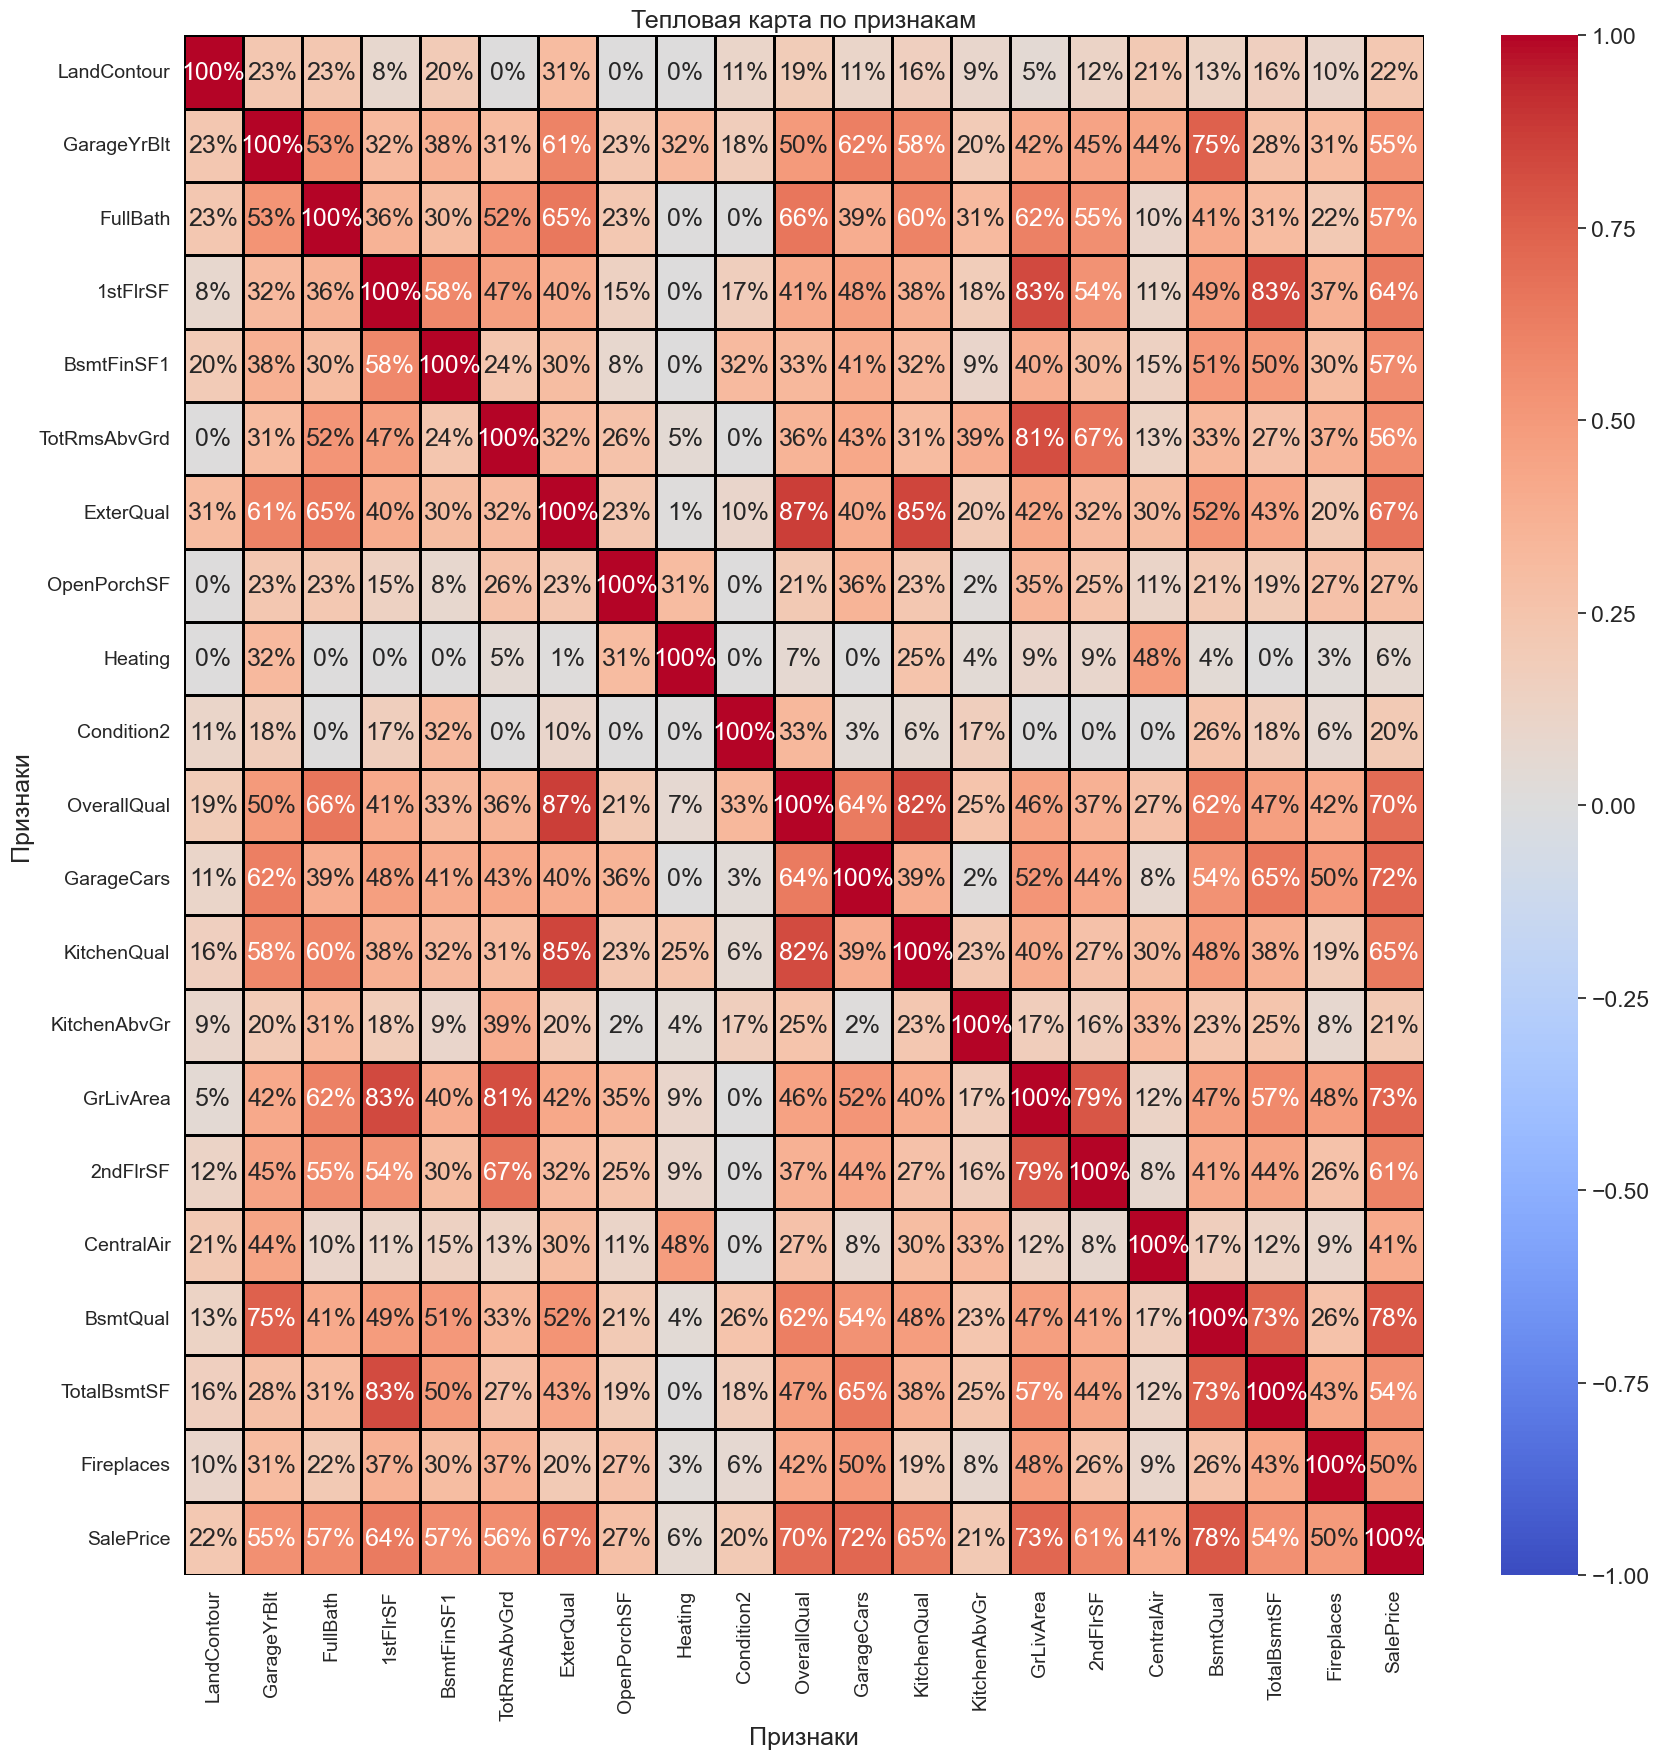

In [50]:
plt.figure(figsize=(20, 20))
sns.heatmap(df1.phik_matrix(interval_cols=['SalePrice', 'GarageYrBlt', 'FullBath', '1stFlrSF', '2ndFlrSF',
                               'BsmtFinSF1', 'TotRmsAbvGrd', 'OpenPorchSF', 'OverallQual',
                               'GarageCars', 'KitchenAbvGr', 'GrLivArea', 'TotalBsmtSF',
                               'Fireplaces']),annot = True, fmt='.0%', vmin=-1, vmax=1,
                                              center= 0, cmap= 'coolwarm', linewidths=1, linecolor='black')
plt.title('Тепловая карта по признакам')
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14, rotation=360)
plt.ylabel('Признаки')
plt.xlabel('Признаки')

In [51]:
# проверим на мультиколлинеарность количественные признаки
train = df1[df1.select_dtypes(include=['int64','float']).columns]

In [52]:
# функция для проверки на мультиколлинеарность
def calc_VIF(x):
  vif= pd.DataFrame()
  vif['variables']=x.columns
  vif["VIF"]=[variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
  return(vif)


In [53]:
# мультиколлинеарность на обучающих данных
calc_VIF(train)

,variables,VIF
0,GarageYrBlt,83.719612
1,FullBath,18.673128
2,1stFlrSF,1293.954622
3,BsmtFinSF1,3.103593
4,TotRmsAbvGrd,66.647578
5,OpenPorchSF,1.806955
6,OverallQual,78.634632
7,GarageCars,20.189538
8,KitchenAbvGr,44.284935
9,GrLivArea,2102.842877


Для набора данных с большим количеством функций, допустимо ограничение VIF в 10. В нашем датафрейме VIF определенных признаков зашкаливает. Также видим значительную корреляцию признаков по тепловой карте. По метрике будет понятно, как это влияние проявиться.

#### Подготовка данных к обучению

In [54]:
# извлекаем признаки
X = df1.drop(['SalePrice'], axis=1)

In [55]:
# извлекаем целевой признак
y = df1['SalePrice']

In [56]:
# выделяем 80% данных для обучающей выборки, остальные данные для валидации
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size =0.2, random_state =RANDOM_STATE)


In [57]:
# сбросим индексы
for i in [X_train, X_valid, y_train, y_valid]:
    i.reset_index(drop=True, inplace=True)

In [58]:
print('Форма обучающей выборки:', X_train.shape)
print('Форма тестовой выборки:', X_valid.shape)

Форма обучающей выборки: (1051, 20)
Форма тестовой выборки: (263, 20)


In [59]:
X_train.head()

,LandContour,GarageYrBlt,FullBath,1stFlrSF,BsmtFinSF1,TotRmsAbvGrd,ExterQual,OpenPorchSF,Heating,Condition2,OverallQual,GarageCars,KitchenQual,KitchenAbvGr,GrLivArea,2ndFlrSF,CentralAir,BsmtQual,TotalBsmtSF,Fireplaces
0,Lvl,1954.0,1,1128,812,5,TA,0,GasA,Norm,5,1,TA,1,1128,0,Y,TA,936,0
1,Lvl,1965.0,1,1301,405,5,TA,0,GasA,Norm,5,2,Fa,1,1301,0,Y,TA,1145,0
2,Lvl,2004.0,2,970,0,7,Gd,40,GasA,Norm,7,2,Gd,1,1709,739,Y,Gd,970,0
3,Lvl,1916.0,1,624,0,7,TA,0,GasA,Norm,5,3,TA,1,1344,720,N,TA,624,0
4,Lvl,1996.0,2,1277,0,7,Gd,0,GasA,Norm,7,3,Gd,1,2344,1067,Y,Gd,1264,1


In [60]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LandContour   1051 non-null   object 
 1   GarageYrBlt   1051 non-null   float64
 2   FullBath      1051 non-null   int64  
 3   1stFlrSF      1051 non-null   int64  
 4   BsmtFinSF1    1051 non-null   int64  
 5   TotRmsAbvGrd  1051 non-null   int64  
 6   ExterQual     1051 non-null   object 
 7   OpenPorchSF   1051 non-null   int64  
 8   Heating       1051 non-null   object 
 9   Condition2    1051 non-null   object 
 10  OverallQual   1051 non-null   int64  
 11  GarageCars    1051 non-null   int64  
 12  KitchenQual   1051 non-null   object 
 13  KitchenAbvGr  1051 non-null   int64  
 14  GrLivArea     1051 non-null   int64  
 15  2ndFlrSF      1051 non-null   int64  
 16  CentralAir    1051 non-null   object 
 17  BsmtQual      1051 non-null   object 
 18  TotalBsmtSF   1051 non-null 

### Вывод

Проведена предобработка и исследовательский анализ данных. Данные готовы к обучению. Для оценки метрики будем использовать перекрестную проверку. Попробуем модель Ridge, которая оснащена методами регуляризации, которые вводят штраф за большие коэффициенты в модели.

## Обучение моделей

### Трансформеры

In [61]:
# трансформер для линейных моделей соберем из ОНЕ для категориальных признаков, 
# к числовым - StandardScaler
linear_transformer = make_column_transformer(
    (OrdinalEncoder(
         handle_unknown='use_encoded_value', unknown_value=-1),
     make_column_selector(
         dtype_include=['category', 'object'])),
    (StandardScaler(), make_column_selector(dtype_include='number')),
    remainder='drop')

In [62]:
# трансформер для нелинейных моделей из ОЕ для категориальных признаков, 
# числовые оставим как есть.
ensemble_transformer = make_column_transformer(
    (OrdinalEncoder(
         handle_unknown='use_encoded_value', unknown_value=-1),
     make_column_selector(
         dtype_include=['category', 'object'])),
    (MaxAbsScaler(), make_column_selector(dtype_include='number')),
     remainder='drop', verbose_feature_names_out=False)

### Ridge

In [63]:
# pipeline Ridge
pipe_rid = make_pipeline(linear_transformer, Ridge(random_state=RANDOM_STATE))


In [64]:
# подбираем гиперпарамаметры для модели Ridge
param_grid = {'ridge__alpha': np.logspace(1,3,10,30)}

grid_search_rid = GridSearchCV(pipe_rid,
                               param_grid,
                               scoring = 'r2',
                               cv=3,
                               n_jobs=-1,
                               verbose=1)


In [65]:
%%time

# инициализируем модель Ridge
grid_search_rid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 315 ms, sys: 100 ms, total: 415 ms
Wall time: 226 ms


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x14eeeb010>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x154210dd0>)])),
                                       ('ridge', Ridge(random_state=12345))]),
             n_jobs=-1,
             param_grid={'ridge__alpha': array([  10.        ,   16.68100537,   27.82559402,   46.41588834,
         77.42636827,  129.1549665 ,  215.443469  ,  359.38136638,
        599.48425032, 1000.        ])},
             scoring='r2', verbose=1)

In [66]:
# выводим модель Ridge с лучшими гиперпараметрами
grid_search_rid.best_params_

{'ridge__alpha': 27.825594022071243}

In [67]:
# R2 для лучшей модели Ridge
grid_search_rid_score = (grid_search_rid.best_score_).round(4)
print(grid_search_rid_score)

0.8547


###  Модель RandomForestRegressor

In [68]:
# pipeline RandomForestRegressor
pipe_rf = make_pipeline(ensemble_transformer,
    RandomForestRegressor( n_jobs=-1,
                           verbose=0,
                           random_state=RANDOM_STATE))


In [69]:
# подбираем гиперпарамаметры для RandomForestRegressor
param_grid = {'randomforestregressor__max_depth': range(1,21,5),
              'randomforestregressor__n_estimators':range(10,510,100),
              'randomforestregressor__min_samples_leaf': range (3, 10)}

grid_search_rfr = GridSearchCV(pipe_rf,
                               param_grid,
                               scoring = 'r2',
                               cv=3,
                               verbose=1)

In [70]:
%%time

# инициализируем модель RandomForestRegressor
grid_search_rfr.fit(X_train, y_train)

Fitting 3 folds for each of 140 candidates, totalling 420 fits
CPU times: user 38.4 s, sys: 4.87 s, total: 43.2 s
Wall time: 45.4 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x14eeebf90>),
                                                                        ('maxabsscaler',
                                                                         MaxAbsScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x14eee8790>)],
                                                          verbose_feature_names_out=False)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=12345))]),
             param_grid={'randomforestregressor__max_depth': range(1, 21, 5),
                         'randomforestregressor__min_samples_leaf': range(3, 10),
                         'randomforestregressor__n_estimators': range(10, 510, 100)},
             scoring='r2', verbose=1)

In [71]:
# выводим модель RandomForestRegressor с лучшими гиперпараметрами
grid_search_rfr.best_estimator_


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x14e519c10>),
                                                 ('maxabsscaler',
                                                  MaxAbsScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x153ce6690>)],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=16, min_samples_leaf=3,
                                       n_estimators=310, n_jobs=-1,
                                       random_state=12345))])

In [72]:
# R2 для лучшей модели RandomForestRegressor
grid_search_rfr_score = (grid_search_rfr.best_score_).round(4)
print(grid_search_rfr_score)

0.8508


### Модель CatBoostRegressor

In [73]:
# pipeline CatBoostRegressor
pipe_cat = make_pipeline(ensemble_transformer,
     CatBoostRegressor(logging_level='Silent',
                        loss_function='RMSE',
                       random_state=RANDOM_STATE))

In [74]:
# подбираем гиперпарамаметры для модели CatBoostRegressor
param_grid = {'catboostregressor__max_depth': [ 3, 5, 7, 9],
              'catboostregressor__learning_rate': [0.01, 0.1]}

grid_search_cbr = GridSearchCV(pipe_cat,
                               param_grid,
                               scoring = 'r2',
                               cv=3,
                               verbose=1)


In [75]:
%%time

# инициализируем модель CatBoostRegressor
grid_search_cbr.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
CPU times: user 1min 8s, sys: 13 s, total: 1min 21s
Wall time: 23.6 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x14eeebf90>),
                                                                        ('maxabsscaler',
                                                                         MaxAbsScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x14eee8790>)],
                                                          verbose_feature_names_out=False)),
                                       ('catboostregressor',
                                        <catboost.core.CatBoostRegressor object at 0x1543e5fd0>)]),
             param_grid={'catboostregressor__learning_rate': [0.01, 0.1],
                         'catboostregressor__max_depth': [3, 5, 7, 9]},
             scoring='r2', verbose=1)

In [76]:
# выводим модель CatBoostRegressor с лучшими гиперпараметрами
grid_search_cbr.best_params_

{'catboostregressor__learning_rate': 0.01, 'catboostregressor__max_depth': 3}

In [77]:
# R2 для лучшей модели CatBoostRegressor
grid_search_cbr_score = (grid_search_cbr.best_score_).round(4)
print(grid_search_cbr_score)

0.874


### Модель LightGBMRegressor

In [78]:
# pipeline LightGBMRegressor
pipe_lgr = make_pipeline(ensemble_transformer,
                        lgb.LGBMRegressor(n_jobs=-1, 
                                           verbosity=-1, 
                                           random_state=RANDOM_STATE))


In [79]:
# подбираем гиперпарамаметры для модели LightGBMRegressor
param_grid = {
    'lgbmregressor__max_depth':[-1, 1, 3],
    'lgbmregressor__num_leaves':[3, 5, 7],
    'lgbmregressor__learning_rate':[ 0.01, 0.1, 0.5],
    'lgbmregressor__n_estimators' : [50, 100, 200],

}
              
grid_search_lgr = GridSearchCV(pipe_lgr, 
                      param_grid, 
                      scoring='r2',
                      cv=3,
                      n_jobs=-1, 
                      verbose=1)

In [80]:
%%time 

# инициализируем модель LightGBMRegressor
grid_search_lgr.fit(X_train, y_train)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
CPU times: user 506 ms, sys: 248 ms, total: 754 ms
Wall time: 14.1 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x14eeebf90>),
                                                                        ('maxabsscaler',
                                                                         MaxAbsScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x14eee8790>)],
                                                          verbose_feature_names_out=False)),
                                       ('lgbmregressor',
                                        LGBMRegressor(n_jobs=-1,
                                                      random_state=12345,
                                                      verbosity=-1))]),
             n_jobs=-1,
             param_grid={'lgbmregressor__learning_rate': [0.01, 0.1, 0.5],
                         'lgbmregressor__max_depth': [-1, 1, 3],
                         'lgbmregressor__n_estimators': [50, 100, 200],
                         'lgbmregressor__num_leaves': [3, 5, 7]},
             scoring='r2', verbose=1)

In [81]:
# выводим модель LightGBMRegressor с лучшими гиперпараметрами
grid_search_lgr.best_params_

{'lgbmregressor__learning_rate': 0.1,
 'lgbmregressor__max_depth': -1,
 'lgbmregressor__n_estimators': 200,
 'lgbmregressor__num_leaves': 3}

In [82]:
# R2 для лучшей модели LightGBMRegressor
grid_search_lgr_score = (grid_search_lgr.best_score_).round(4)
print(grid_search_lgr_score)

0.8754


### Вывод

Обучили 4 модели: Ridge, RandomForestRegressor, CatBoostRegressor, LightGBMRegressor. Получили следующие показания определяющей метрики R2.

In [83]:
# сводная таблица по показателям R2:
index = ['Ridge',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'LightGBMRegressor']

data = {'R2':[grid_search_rid_score,
              grid_search_rfr_score,
              grid_search_cbr_score,
              grid_search_lgr_score
                   ]}

data = pd.DataFrame(data=data, index=index)

data.sort_values(by ='R2', ascending=False)

,R2
LightGBMRegressor,0.8754
CatBoostRegressor,0.8740
Ridge,0.8547
RandomForestRegressor,0.8508


## Тестирование и анализ лучшей модели

In [84]:
predictions = grid_search_lgr.predict(X_valid)

In [85]:
R2 = r2_score(y_valid, predictions)
print("R2 для LightGBMRegressor на валидационной выборке: ", R2.round(4))

R2 для LightGBMRegressor на валидационной выборке:  0.8781


R2-коэффициент детерминации – мера, которая показывает, насколько хорошо модель подходит для данных. R2-коэффициент может принимать значения от 0 до 1, где 1 означает идеальное соответствие. 

In [86]:
# функция для расчета MAPE
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [87]:
MAPE = MAPE(y_valid, predictions)
print("MAPE для LightGBMRegressor на валидационной выборке: ", MAPE)

MAPE для LightGBMRegressor на валидационной выборке:  9.55337153513478


MAPE можно интерпретировать как величину, обратную точности модели, но более конкретно, как среднюю процентную разницу между прогнозами и их предполагаемыми целями в наборе данных. Например, наш MAPE равен 9,55%, то ваши прогнозы в среднем на 9,55% отличаются от фактических значений, к которым они стремились.

## Заключение

#### Выведем коэффиценты важности признаков, влияющих на цену жилья.

In [88]:
%%time

pd.DataFrame(
    grid_search_cbr.best_estimator_[-1].feature_importances_, 
    index=grid_search_cbr.best_estimator_[:-1].get_feature_names_out(),
    columns=['Важность признака']
).sort_values(by='Важность признака', ascending=False)

CPU times: user 3.85 ms, sys: 3.75 ms, total: 7.6 ms
Wall time: 1.36 ms


,Важность признака
OverallQual,29.690880
GrLivArea,20.677937
BsmtFinSF1,7.108891
TotalBsmtSF,6.513202
ExterQual,6.510799
BsmtQual,5.913850
GarageCars,4.682856
Fireplaces,3.306695
1stFlrSF,3.094523
KitchenQual,2.711226


Проведена следующая работа:
- Загрузка, предобработка, исследовательский анализ данных.
- Обучили 4 модели: Ridge, RandomForestRegressor, CatBoostRegressor, LightGBMRegressor. Выбрана лучшая модель LightGBMRegressor, результат метрики на обучающей части R2 = 0.8754, на валидационной части R2 = 0.8781.

Прогнозы в среднем ошибаются на 9.55%. В тройку самых влиятельных признаков можно отнести:
 1. Качество отделки (ремонт).
 2. Площадь надземной части жилья.
 3. "Готовая" площадь типа 1.

In [89]:
# выводим информацию об примере выгрузки предсказаний
DATA_SAMPLE = '/Users/urvanov_aleksandr/Documents/Yandex/Projects/test_webbee/sample_submission.csv'

df3 = pd.read_csv(f'{DATA_SAMPLE}')
df3.head(3)

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570


In [90]:
# предсказание на тестовой выборке
prediction_test = grid_search_lgr.predict(df2)
df_final = pd.DataFrame(df3['Id']).join(pd.DataFrame(prediction_test, df2.index,['SalePrice']))
df_final

,Id,SalePrice
0,1461,125404.400161
1,1462,158307.566279
2,1463,169560.917110
3,1464,172304.354310
4,1465,207945.438319
5,1466,162014.063538
6,1467,155264.648083
7,1468,158477.359715
8,1469,184556.326086
9,1470,120674.175937


In [91]:
# создаем файл с предсказаниями
df_final.to_csv('/Users/urvanov_aleksandr/Documents/Yandex/Projects/test_webbee/submission.csv', index= False)

In [92]:
# проверяем формат тестовых предсказаний
DATA_SAMPLE_TEST = '/Users/urvanov_aleksandr/Documents/Yandex/Projects/test_webbee/submission.csv'

df4 = pd.read_csv(f'{DATA_SAMPLE_TEST}')
df4.head(3)

,Id,SalePrice
0,1461,125404.400161
1,1462,158307.566279
2,1463,169560.917110
